In [1]:
# =================================
# COMP0078 Coursework 2 Q1.6 RE1.2
# Douglas Chiang
# 15055142
# =================================
cd /Users/DouglasChiang/Google Drive_HNC/Colab Notebooks/COMP0078/CW2/Q1

/Users/DouglasChiang/Google Drive_HNC/Colab Notebooks/COMP0078/CW2/Q1


In [2]:
ls

Assignment_2_Question_1a_v3.ipynb    assignment_2_question_1f_1_v1.py
Assignment_2_Question_1e_2_v1.ipynb  dtest123.dat*
Icon?                                dtrain123.dat*
Plots/                               zipcombo.dat*
Q1 Trial.ipynb


Libraries:

In [3]:
import time
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

Functions for data

In [4]:
def load_dat(fname, Full_Data = False):
    dat = pd.read_csv(fname, sep='\s+', header=None).to_numpy()
    if Full_Data == False:
        y = dat[:, 0].astype(np.int) - 1  # we are zero-based indexing
    else:
        y = dat[:, 0].astype(np.int)
    
    X = dat[:, 1:].astype(np.float64)
    return X, y

def Plot_Accuracy_SV(Ker_para, run, n_epochs, Train_accuracy_All, Test_accuracy_All):
    fig1, ax1 = plt.subplots()

    ax1.plot(range(1, n_epochs), Train_accuracy_All, color='red', label='Training accuracy')
    ax1.plot(range(1, n_epochs), Test_accuracy_All, color='blue', label='Testing accuracy')

    plt.xlabel('Epoch(s)')
    leg = ax1.legend(bbox_to_anchor=(1.5, 1.02), loc='upper right', frameon=False)
    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/COMP0078/CW2/Q1/Plots/Q1a/d_{Ker_para}_run_{run}_Accuracy_SV.png")

def kFold(data_idx, fold, folds):
    # Return split data indices sets for k-fold validation
    
    if fold > folds - 1:
        raise Exception('fold number exceeds total folds available')
    
    m        = len(data_idx)
    size     = m // folds
    data_validate_idx = data_idx[fold*size:(fold + 1)*size]

    if fold == 0:
        # first fold
        data_train_idx = data_idx[(fold+1)*size:]

    elif fold == folds - 1:
        # last fold
        data_train_idx = data_idx[:fold*size]

    else:
        # middle fold
        data_train1_idx = data_idx[:fold*size]
        data_train2_idx = data_idx[(fold+1)*size:]
        data_train_idx  = np.concatenate((data_train1_idx, data_train2_idx), axis=0)
    
    return data_train_idx, data_validate_idx

Kernel Calculation

In [5]:
class KernelFunctor:
    """
    Calculate the Kernel values and put them in a matrix
    """
    def __init__(self, Ker_Meth="Poly", Ker_para=2):
        self.Ker_Meth = Ker_Meth
        self.Ker_para = Ker_para
        #self.X_idx = 
    
    def kernel_fn(self, X):
        if self.Ker_Meth == "Poly":
            return (X.dot(X.T))**self.Ker_para
        elif self.Ker_Meth == "Gau":
            pass# return np.exp(-self.Ker_para*np.linalg.norm(p_vec - q_vec)**2)
        else:
            assert False, "Kernel Method Undefined"

K - Class Classifier: One vs One Online Perceptron


In [6]:
class OvO_OnlinePerceptron:
    """
    One-vs-One
    """
    def __init__(self, alphas, classifier_values, kernel_matrix, n_classes=3):
        self.alphas              = alphas
        self.kernel_matrix       = kernel_matrix
        self.n_classes           = n_classes
        self.n_classifiers       = int(self.n_classes*(self.n_classes - 1)/2)
        self.classifier_values   = classifier_values

    def fit(self, ran_train_sample_idx, X, y):
        n_samples, n_dim = X.shape

        # record down data
        self.n_dim                = n_dim
        self.n_samples            = range(n_samples)
        self.ran_train_sample_idx = ran_train_sample_idx
        # ------------------------------------------------------
        for i in self.n_samples:
            cls_vals           = self._get_classifier_vals(self.ran_train_sample_idx[i])
            preds              = self.sign(cls_vals)
            truth              = self._label_to_custom_onehot(y[i])
            self.alphas[:, i] += np.where(preds != truth, truth, 0)

        return self.alphas

    def _get_classifier_vals(self, sample_idx):
        """
        This is the classifier:
        .. math::
            w(x) = \sum_i \alpha_i K(x_i, x)
        Args:
            x (np.ndarray): the input feature you would like to classify
        Return:
            An array of size (n_classes,). Each value represents the inner product
            sum between support vectors of a classifier and the incoming feature.
        """
        ret           = np.zeros((self.n_classifiers,))
        kernel_values = self.kernel_matrix[self.ran_train_sample_idx, sample_idx]
        ret          += self.alphas.dot(kernel_values)
        assert ret.shape == (self.n_classifiers,)
        return ret

    def predict(self, sample_idx):
        cls_vals = self._get_classifier_vals(sample_idx)
        return np.argmax(cls_vals)

    @staticmethod
    def sign(val):
        ret = np.where(val <= 0.0, -1, 1)
        return ret

    def _label_to_custom_onehot(self, label: int):
        labels = np.zeros((self.n_classifiers,))
        for i in range(self.n_classifiers):
            if self.classifier_values[i][0] == label:
                labels[i] = 1
            elif self.classifier_values[i][1] == label:
                labels[i] = -1
        return labels

In [7]:
def OvO_Prediction(alphas, kernel_vals, classifier_values):
    m_test = kernel_vals.shape[1]
    y_pred = (alphas.dot(kernel_vals) > 0)*2 - 1
    poll = np.zeros((10, m_test))
    for cls_idx in range(classifier_values.shape[0]):
        pve_votes = (y_pred[cls_idx, :] == 1)
        nve_votes = (y_pred[cls_idx, :] == -1)

        poll[int(classifier_values[cls_idx, 0]), pve_votes] += 1
        poll[int(classifier_values[cls_idx, 1]), nve_votes] += 1
    
    return np.argmax(poll, axis = 0)

In [8]:
# Trial data set:
# X_train, y_train = load_dat("dtrain123.dat", Full_Data = False)
# X_test, y_test   = load_dat("dtest123.dat", Full_Data = False)
# X_dataset = np.vstack((X_train, X_test))
# Y_dataset = np.hstack((y_train, y_test))

# Full data set:
X_dataset, Y_dataset = load_dat("zipcombo.dat", Full_Data = True)
# split_pt = round(X_dataset.shape[0]*0.2)
# X_dataset = X_dataset[:split_pt]
# Y_dataset = Y_dataset[:split_pt]

Run: 1
d = 1
Precalculate Kernel...
**Kernel calculation finished in 2.3844 seconds
fold :1
**Training: Epoch 1 finished in 7.4397 seconds
**Training: Epoch 2 finished in 7.1383 seconds
**Training: Epoch 3 finished in 8.7533 seconds
**Training: Epoch 4 finished in 7.8807 seconds
**Training: Epoch 5 finished in 8.5928 seconds
**Training: Epoch 6 finished in 7.0126 seconds
**Training: Epoch 7 finished in 7.7129 seconds
**Training: Epoch 8 finished in 8.9469 seconds
**Training: Epoch 9 finished in 4.7660 seconds
**Training: Epoch 10 finished in 7.5794 seconds
**Training: Epoch 11 finished in 7.3208 seconds
**Training: Epoch 12 finished in 8.2354 seconds
**Training: Epoch 13 finished in 7.6719 seconds
**Training: Epoch 14 finished in 7.2074 seconds
**Training: Epoch 15 finished in 7.3622 seconds
**Training: Epoch 16 finished in 7.9936 seconds
**Training: Epoch 17 finished in 6.7587 seconds
**Training: Epoch 18 finished in 5.3739 seconds
**Training: Epoch 19 finished in 5.7260 seconds
**Tra

**Training: Epoch 9 finished in 7.5758 seconds
**Training: Epoch 10 finished in 7.8551 seconds
**Training: Epoch 11 finished in 7.5315 seconds
**Training: Epoch 12 finished in 9.0169 seconds
**Training: Epoch 13 finished in 9.1447 seconds
**Training: Epoch 14 finished in 7.1113 seconds
**Training: Epoch 15 finished in 9.4199 seconds
**Training: Epoch 16 finished in 9.4365 seconds
**Training: Epoch 17 finished in 8.9348 seconds
**Training: Epoch 18 finished in 9.8943 seconds
**Training: Epoch 19 finished in 6.9657 seconds
**Training: Epoch 20 finished in 7.7461 seconds
fold :5
**Training: Epoch 1 finished in 7.0952 seconds
**Training: Epoch 2 finished in 6.8652 seconds
**Training: Epoch 3 finished in 7.2646 seconds
**Training: Epoch 4 finished in 7.3480 seconds
**Training: Epoch 5 finished in 7.7009 seconds
**Training: Epoch 6 finished in 6.9584 seconds
**Training: Epoch 7 finished in 6.7941 seconds
**Training: Epoch 8 finished in 6.8479 seconds
**Training: Epoch 9 finished in 8.4294 se

**Training: Epoch 17 finished in 7.2978 seconds
**Training: Epoch 18 finished in 6.5366 seconds
**Training: Epoch 19 finished in 7.0007 seconds
**Training: Epoch 20 finished in 7.4446 seconds
fold :3
**Training: Epoch 1 finished in 7.6475 seconds
**Training: Epoch 2 finished in 6.6671 seconds
**Training: Epoch 3 finished in 7.1035 seconds
**Training: Epoch 4 finished in 9.3331 seconds
**Training: Epoch 5 finished in 8.1178 seconds
**Training: Epoch 6 finished in 7.1178 seconds
**Training: Epoch 7 finished in 7.7129 seconds
**Training: Epoch 8 finished in 6.9196 seconds
**Training: Epoch 9 finished in 7.1686 seconds
**Training: Epoch 10 finished in 7.3425 seconds
**Training: Epoch 11 finished in 6.7417 seconds
**Training: Epoch 12 finished in 6.7139 seconds
**Training: Epoch 13 finished in 7.0207 seconds
**Training: Epoch 14 finished in 7.4851 seconds
**Training: Epoch 15 finished in 6.8246 seconds
**Training: Epoch 16 finished in 9.7552 seconds
**Training: Epoch 17 finished in 6.8985 s

**Training: Epoch 5 finished in 6.8121 seconds
**Training: Epoch 6 finished in 6.7473 seconds
**Training: Epoch 7 finished in 7.2615 seconds
**Training: Epoch 8 finished in 7.1694 seconds
**Training: Epoch 9 finished in 6.8501 seconds
**Training: Epoch 10 finished in 6.7224 seconds
**Training: Epoch 11 finished in 6.9507 seconds
**Training: Epoch 12 finished in 7.5130 seconds
**Training: Epoch 13 finished in 7.0627 seconds
**Training: Epoch 14 finished in 10.6559 seconds
**Training: Epoch 15 finished in 7.0129 seconds
**Training: Epoch 16 finished in 7.4007 seconds
**Training: Epoch 17 finished in 8.2179 seconds
**Training: Epoch 18 finished in 7.3852 seconds
**Training: Epoch 19 finished in 7.5800 seconds
**Training: Epoch 20 finished in 7.0424 seconds
fold :2
**Training: Epoch 1 finished in 6.8151 seconds
**Training: Epoch 2 finished in 12.0292 seconds
**Training: Epoch 3 finished in 9.8638 seconds
**Training: Epoch 4 finished in 6.4923 seconds
**Training: Epoch 5 finished in 6.9777 

**Training: Epoch 15 finished in 6.9962 seconds
**Training: Epoch 16 finished in 6.8247 seconds
**Training: Epoch 17 finished in 6.6963 seconds
**Training: Epoch 18 finished in 6.6633 seconds
**Training: Epoch 19 finished in 7.3929 seconds
**Training: Epoch 20 finished in 7.2969 seconds
fold :5
**Training: Epoch 1 finished in 6.6790 seconds
**Training: Epoch 2 finished in 7.4470 seconds
**Training: Epoch 3 finished in 7.0501 seconds
**Training: Epoch 4 finished in 7.1539 seconds
**Training: Epoch 5 finished in 7.0804 seconds
**Training: Epoch 6 finished in 6.7418 seconds
**Training: Epoch 7 finished in 6.6016 seconds
**Training: Epoch 8 finished in 6.9491 seconds
**Training: Epoch 9 finished in 7.0594 seconds
**Training: Epoch 10 finished in 7.0539 seconds
**Training: Epoch 11 finished in 6.6992 seconds
**Training: Epoch 12 finished in 6.8464 seconds
**Training: Epoch 13 finished in 7.9984 seconds
**Training: Epoch 14 finished in 6.8180 seconds
**Training: Epoch 15 finished in 7.2797 s

**Training: Epoch 20 finished in 6.9592 seconds
fold :2
**Training: Epoch 1 finished in 6.8438 seconds
**Training: Epoch 2 finished in 6.8239 seconds
**Training: Epoch 3 finished in 7.2109 seconds
**Training: Epoch 4 finished in 9.9392 seconds
**Training: Epoch 5 finished in 7.0064 seconds
**Training: Epoch 6 finished in 7.2502 seconds
**Training: Epoch 7 finished in 6.9768 seconds
**Training: Epoch 8 finished in 7.1307 seconds
**Training: Epoch 9 finished in 7.2426 seconds
**Training: Epoch 10 finished in 6.8912 seconds
**Training: Epoch 11 finished in 6.5774 seconds
**Training: Epoch 12 finished in 6.9726 seconds
**Training: Epoch 13 finished in 6.9901 seconds
**Training: Epoch 14 finished in 7.0983 seconds
**Training: Epoch 15 finished in 8.6813 seconds
**Training: Epoch 16 finished in 6.7903 seconds
**Training: Epoch 17 finished in 6.8273 seconds
**Training: Epoch 18 finished in 7.1340 seconds
**Training: Epoch 19 finished in 6.9873 seconds
**Training: Epoch 20 finished in 7.7847 s

**Training: Epoch 10 finished in 6.9337 seconds
**Training: Epoch 11 finished in 7.1542 seconds
**Training: Epoch 12 finished in 6.5813 seconds
**Training: Epoch 13 finished in 6.7094 seconds
**Training: Epoch 14 finished in 6.7515 seconds
**Training: Epoch 15 finished in 7.1387 seconds
**Training: Epoch 16 finished in 7.1779 seconds
**Training: Epoch 17 finished in 6.9353 seconds
**Training: Epoch 18 finished in 7.2969 seconds
**Training: Epoch 19 finished in 6.6106 seconds
**Training: Epoch 20 finished in 6.6608 seconds
d = 4
Precalculate Kernel...
**Kernel calculation finished in 7.2244 seconds
fold :1
**Training: Epoch 1 finished in 6.6646 seconds
**Training: Epoch 2 finished in 6.7943 seconds
**Training: Epoch 3 finished in 7.3157 seconds
**Training: Epoch 4 finished in 7.3390 seconds
**Training: Epoch 5 finished in 7.2970 seconds
**Training: Epoch 6 finished in 6.6577 seconds
**Training: Epoch 7 finished in 7.0288 seconds
**Training: Epoch 8 finished in 6.6409 seconds
**Training:

**Training: Epoch 18 finished in 6.7582 seconds
**Training: Epoch 19 finished in 6.8603 seconds
**Training: Epoch 20 finished in 6.5970 seconds
fold :4
**Training: Epoch 1 finished in 6.6900 seconds
**Training: Epoch 2 finished in 6.8341 seconds
**Training: Epoch 3 finished in 6.7829 seconds
**Training: Epoch 4 finished in 7.1940 seconds
**Training: Epoch 5 finished in 6.6549 seconds
**Training: Epoch 6 finished in 7.2360 seconds
**Training: Epoch 7 finished in 6.7588 seconds
**Training: Epoch 8 finished in 6.7042 seconds
**Training: Epoch 9 finished in 6.8196 seconds
**Training: Epoch 10 finished in 7.0147 seconds
**Training: Epoch 11 finished in 6.6649 seconds
**Training: Epoch 12 finished in 6.9382 seconds
**Training: Epoch 13 finished in 6.7672 seconds
**Training: Epoch 14 finished in 6.9581 seconds
**Training: Epoch 15 finished in 6.7912 seconds
**Training: Epoch 16 finished in 6.9092 seconds
**Training: Epoch 17 finished in 6.9062 seconds
**Training: Epoch 18 finished in 6.8758 s

**Training: Epoch 6 finished in 7.0261 seconds
**Training: Epoch 7 finished in 6.6876 seconds
**Training: Epoch 8 finished in 6.6646 seconds
**Training: Epoch 9 finished in 6.8622 seconds
**Training: Epoch 10 finished in 6.9785 seconds
**Training: Epoch 11 finished in 6.6663 seconds
**Training: Epoch 12 finished in 6.8335 seconds
**Training: Epoch 13 finished in 9.4783 seconds
**Training: Epoch 14 finished in 6.6499 seconds
**Training: Epoch 15 finished in 6.7062 seconds
**Training: Epoch 16 finished in 7.3321 seconds
**Training: Epoch 17 finished in 6.6521 seconds
**Training: Epoch 18 finished in 6.8629 seconds
**Training: Epoch 19 finished in 6.6885 seconds
**Training: Epoch 20 finished in 6.8523 seconds
fold :3
**Training: Epoch 1 finished in 6.7650 seconds
**Training: Epoch 2 finished in 7.1018 seconds
**Training: Epoch 3 finished in 6.8363 seconds
**Training: Epoch 4 finished in 6.6227 seconds
**Training: Epoch 5 finished in 6.6307 seconds
**Training: Epoch 6 finished in 6.7500 se

**Training: Epoch 13 finished in 6.7439 seconds
**Training: Epoch 14 finished in 6.9044 seconds
**Training: Epoch 15 finished in 6.9662 seconds
**Training: Epoch 16 finished in 6.7036 seconds
**Training: Epoch 17 finished in 8.3109 seconds
**Training: Epoch 18 finished in 9.0489 seconds
**Training: Epoch 19 finished in 6.7543 seconds
**Training: Epoch 20 finished in 6.6227 seconds
fold :5
**Training: Epoch 1 finished in 6.6627 seconds
**Training: Epoch 2 finished in 6.8946 seconds
**Training: Epoch 3 finished in 6.7433 seconds
**Training: Epoch 4 finished in 6.8890 seconds
**Training: Epoch 5 finished in 6.6422 seconds
**Training: Epoch 6 finished in 6.5669 seconds
**Training: Epoch 7 finished in 6.7274 seconds
**Training: Epoch 8 finished in 6.8664 seconds
**Training: Epoch 9 finished in 6.8644 seconds
**Training: Epoch 10 finished in 6.6667 seconds
**Training: Epoch 11 finished in 6.6544 seconds
**Training: Epoch 12 finished in 7.1705 seconds
**Training: Epoch 13 finished in 6.6115 s

fold :3
**Training: Epoch 1 finished in 6.6306 seconds
**Training: Epoch 2 finished in 6.5802 seconds
**Training: Epoch 3 finished in 7.1278 seconds
**Training: Epoch 4 finished in 6.5302 seconds
**Training: Epoch 5 finished in 6.7795 seconds
**Training: Epoch 6 finished in 6.6475 seconds
**Training: Epoch 7 finished in 6.9481 seconds
**Training: Epoch 8 finished in 6.5716 seconds
**Training: Epoch 9 finished in 6.6633 seconds
**Training: Epoch 10 finished in 6.6818 seconds
**Training: Epoch 11 finished in 7.1485 seconds
**Training: Epoch 12 finished in 8.0310 seconds
**Training: Epoch 13 finished in 6.7318 seconds
**Training: Epoch 14 finished in 6.7935 seconds
**Training: Epoch 15 finished in 6.6384 seconds
**Training: Epoch 16 finished in 10.1230 seconds
**Training: Epoch 17 finished in 6.8406 seconds
**Training: Epoch 18 finished in 6.7793 seconds
**Training: Epoch 19 finished in 6.5784 seconds
**Training: Epoch 20 finished in 6.9281 seconds
fold :4
**Training: Epoch 1 finished in 

**Training: Epoch 9 finished in 7.2291 seconds
**Training: Epoch 10 finished in 6.8050 seconds
**Training: Epoch 11 finished in 6.7276 seconds
**Training: Epoch 12 finished in 7.0337 seconds
**Training: Epoch 13 finished in 6.7366 seconds
**Training: Epoch 14 finished in 6.7239 seconds
**Training: Epoch 15 finished in 6.7559 seconds
**Training: Epoch 16 finished in 7.1456 seconds
**Training: Epoch 17 finished in 6.8972 seconds
**Training: Epoch 18 finished in 6.7496 seconds
**Training: Epoch 19 finished in 6.8894 seconds
**Training: Epoch 20 finished in 7.0141 seconds
fold :2
**Training: Epoch 1 finished in 9.8311 seconds
**Training: Epoch 2 finished in 6.6799 seconds
**Training: Epoch 3 finished in 6.5492 seconds
**Training: Epoch 4 finished in 6.6877 seconds
**Training: Epoch 5 finished in 6.9153 seconds
**Training: Epoch 6 finished in 6.8882 seconds
**Training: Epoch 7 finished in 6.7583 seconds
**Training: Epoch 8 finished in 6.6574 seconds
**Training: Epoch 9 finished in 7.0148 se

**Training: Epoch 19 finished in 6.9095 seconds
**Training: Epoch 20 finished in 6.8252 seconds
fold :5
**Training: Epoch 1 finished in 7.9345 seconds
**Training: Epoch 2 finished in 6.7532 seconds
**Training: Epoch 3 finished in 6.7011 seconds
**Training: Epoch 4 finished in 6.6608 seconds
**Training: Epoch 5 finished in 6.7297 seconds
**Training: Epoch 6 finished in 6.9325 seconds
**Training: Epoch 7 finished in 6.7774 seconds
**Training: Epoch 8 finished in 6.9698 seconds
**Training: Epoch 9 finished in 7.2033 seconds
**Training: Epoch 10 finished in 6.7441 seconds
**Training: Epoch 11 finished in 6.6583 seconds
**Training: Epoch 12 finished in 7.0394 seconds
**Training: Epoch 13 finished in 6.8515 seconds
**Training: Epoch 14 finished in 6.9865 seconds
**Training: Epoch 15 finished in 6.7785 seconds
**Training: Epoch 16 finished in 6.8181 seconds
**Training: Epoch 17 finished in 6.8333 seconds
**Training: Epoch 18 finished in 6.8299 seconds
**Training: Epoch 19 finished in 6.6517 s

**Training: Epoch 4 finished in 6.7695 seconds
**Training: Epoch 5 finished in 6.6065 seconds
**Training: Epoch 6 finished in 6.6898 seconds
**Training: Epoch 7 finished in 6.7361 seconds
**Training: Epoch 8 finished in 6.6485 seconds
**Training: Epoch 9 finished in 6.9200 seconds
**Training: Epoch 10 finished in 6.5304 seconds
**Training: Epoch 11 finished in 6.5510 seconds
**Training: Epoch 12 finished in 7.1748 seconds
**Training: Epoch 13 finished in 6.6107 seconds
**Training: Epoch 14 finished in 6.6691 seconds
**Training: Epoch 15 finished in 6.7182 seconds
**Training: Epoch 16 finished in 6.7891 seconds
**Training: Epoch 17 finished in 7.1610 seconds
**Training: Epoch 18 finished in 6.6873 seconds
**Training: Epoch 19 finished in 6.5737 seconds
**Training: Epoch 20 finished in 6.8397 seconds
fold :3
**Training: Epoch 1 finished in 6.8235 seconds
**Training: Epoch 2 finished in 6.6006 seconds
**Training: Epoch 3 finished in 7.6946 seconds
**Training: Epoch 4 finished in 7.1556 se

**Training: Epoch 14 finished in 6.6765 seconds
**Training: Epoch 15 finished in 6.6304 seconds
**Training: Epoch 16 finished in 6.6767 seconds
**Training: Epoch 17 finished in 6.8728 seconds
**Training: Epoch 18 finished in 6.9063 seconds
**Training: Epoch 19 finished in 6.9573 seconds
**Training: Epoch 20 finished in 6.8242 seconds
d = 3
Precalculate Kernel...
**Kernel calculation finished in 6.6703 seconds
fold :1
**Training: Epoch 1 finished in 7.0565 seconds
**Training: Epoch 2 finished in 6.5929 seconds
**Training: Epoch 3 finished in 7.0739 seconds
**Training: Epoch 4 finished in 6.6939 seconds
**Training: Epoch 5 finished in 6.6075 seconds
**Training: Epoch 6 finished in 6.6444 seconds
**Training: Epoch 7 finished in 6.5832 seconds
**Training: Epoch 8 finished in 7.0315 seconds
**Training: Epoch 9 finished in 6.8978 seconds
**Training: Epoch 10 finished in 6.7832 seconds
**Training: Epoch 11 finished in 8.9424 seconds
**Training: Epoch 12 finished in 7.5224 seconds
**Training: 

**Training: Epoch 2 finished in 6.1799 seconds
**Training: Epoch 3 finished in 6.4526 seconds
**Training: Epoch 4 finished in 6.4769 seconds
**Training: Epoch 5 finished in 6.4654 seconds
**Training: Epoch 6 finished in 6.2663 seconds
**Training: Epoch 7 finished in 7.5327 seconds
**Training: Epoch 8 finished in 6.2769 seconds
**Training: Epoch 9 finished in 6.3230 seconds
**Training: Epoch 10 finished in 6.3693 seconds
**Training: Epoch 11 finished in 6.2210 seconds
**Training: Epoch 12 finished in 6.6622 seconds
**Training: Epoch 13 finished in 6.3770 seconds
**Training: Epoch 14 finished in 6.2137 seconds
**Training: Epoch 15 finished in 6.5653 seconds
**Training: Epoch 16 finished in 6.6057 seconds
**Training: Epoch 17 finished in 6.6975 seconds
**Training: Epoch 18 finished in 6.2570 seconds
**Training: Epoch 19 finished in 6.4357 seconds
**Training: Epoch 20 finished in 6.2548 seconds
fold :5
**Training: Epoch 1 finished in 6.4278 seconds
**Training: Epoch 2 finished in 6.3527 se

**Training: Epoch 10 finished in 6.7127 seconds
**Training: Epoch 11 finished in 6.6229 seconds
**Training: Epoch 12 finished in 7.2377 seconds
**Training: Epoch 13 finished in 6.7161 seconds
**Training: Epoch 14 finished in 6.9083 seconds
**Training: Epoch 15 finished in 7.0031 seconds
**Training: Epoch 16 finished in 6.7639 seconds
**Training: Epoch 17 finished in 9.7129 seconds
**Training: Epoch 18 finished in 7.3863 seconds
**Training: Epoch 19 finished in 6.8030 seconds
**Training: Epoch 20 finished in 7.0302 seconds
fold :3
**Training: Epoch 1 finished in 6.8839 seconds
**Training: Epoch 2 finished in 8.4963 seconds
**Training: Epoch 3 finished in 7.0640 seconds
**Training: Epoch 4 finished in 6.6875 seconds
**Training: Epoch 5 finished in 6.8318 seconds
**Training: Epoch 6 finished in 7.0452 seconds
**Training: Epoch 7 finished in 6.9851 seconds
**Training: Epoch 8 finished in 6.8272 seconds
**Training: Epoch 9 finished in 6.9701 seconds
**Training: Epoch 10 finished in 7.1786 s

**Training: Epoch 20 finished in 6.8124 seconds
Retrain using 3...
Precalculate Kernel...
**Kernel calculation finished in 6.4922 seconds
**Training: Epoch 1 finished in 4.5705 seconds
**Training: Epoch 2 finished in 8.7216 seconds
**Training: Epoch 3 finished in 10.0655 seconds
**Training: Epoch 4 finished in 9.5483 seconds
**Training: Epoch 5 finished in 9.6098 seconds
**Training: Epoch 6 finished in 9.8157 seconds
**Training: Epoch 7 finished in 9.9015 seconds
**Training: Epoch 8 finished in 9.5191 seconds
**Training: Epoch 9 finished in 9.8625 seconds
**Training: Epoch 10 finished in 9.6393 seconds
**Training: Epoch 11 finished in 9.3327 seconds
**Training: Epoch 12 finished in 9.3621 seconds
**Training: Epoch 13 finished in 13.4934 seconds
**Training: Epoch 14 finished in 10.2852 seconds
**Training: Epoch 15 finished in 12.4694 seconds
**Training: Epoch 16 finished in 9.6979 seconds
**Training: Epoch 17 finished in 9.6299 seconds
**Training: Epoch 18 finished in 9.6751 seconds
**T

**Training: Epoch 5 finished in 6.9942 seconds
**Training: Epoch 6 finished in 7.2097 seconds
**Training: Epoch 7 finished in 6.8449 seconds
**Training: Epoch 8 finished in 7.2873 seconds
**Training: Epoch 9 finished in 6.7467 seconds
**Training: Epoch 10 finished in 6.8867 seconds
**Training: Epoch 11 finished in 6.7776 seconds
**Training: Epoch 12 finished in 7.2198 seconds
**Training: Epoch 13 finished in 7.1765 seconds
**Training: Epoch 14 finished in 6.7397 seconds
**Training: Epoch 15 finished in 7.2020 seconds
**Training: Epoch 16 finished in 6.8541 seconds
**Training: Epoch 17 finished in 7.0630 seconds
**Training: Epoch 18 finished in 6.7651 seconds
**Training: Epoch 19 finished in 6.9434 seconds
**Training: Epoch 20 finished in 6.7338 seconds
fold :4
**Training: Epoch 1 finished in 7.0875 seconds
**Training: Epoch 2 finished in 6.7669 seconds
**Training: Epoch 3 finished in 7.0725 seconds
**Training: Epoch 4 finished in 6.7466 seconds
**Training: Epoch 5 finished in 7.4972 se

**Training: Epoch 13 finished in 8.7582 seconds
**Training: Epoch 14 finished in 6.9288 seconds
**Training: Epoch 15 finished in 6.8119 seconds
**Training: Epoch 16 finished in 6.7082 seconds
**Training: Epoch 17 finished in 7.2140 seconds
**Training: Epoch 18 finished in 7.0072 seconds
**Training: Epoch 19 finished in 7.0684 seconds
**Training: Epoch 20 finished in 7.3957 seconds
fold :2
**Training: Epoch 1 finished in 7.6131 seconds
**Training: Epoch 2 finished in 7.0009 seconds
**Training: Epoch 3 finished in 7.1192 seconds
**Training: Epoch 4 finished in 6.6989 seconds
**Training: Epoch 5 finished in 6.8934 seconds
**Training: Epoch 6 finished in 7.1415 seconds
**Training: Epoch 7 finished in 6.9980 seconds
**Training: Epoch 8 finished in 6.8078 seconds
**Training: Epoch 9 finished in 6.6881 seconds
**Training: Epoch 10 finished in 7.0004 seconds
**Training: Epoch 11 finished in 6.8678 seconds
**Training: Epoch 12 finished in 6.9801 seconds
**Training: Epoch 13 finished in 6.8016 s

**Training: Epoch 2 finished in 11.6064 seconds
**Training: Epoch 3 finished in 11.4854 seconds
**Training: Epoch 4 finished in 7.0416 seconds
**Training: Epoch 5 finished in 7.1685 seconds
**Training: Epoch 6 finished in 11.3730 seconds
**Training: Epoch 7 finished in 11.5066 seconds
**Training: Epoch 8 finished in 11.5007 seconds
**Training: Epoch 9 finished in 11.5509 seconds
**Training: Epoch 10 finished in 10.9440 seconds
**Training: Epoch 11 finished in 11.9956 seconds
**Training: Epoch 12 finished in 12.0315 seconds
**Training: Epoch 13 finished in 12.1719 seconds
**Training: Epoch 14 finished in 11.9061 seconds
**Training: Epoch 15 finished in 11.8918 seconds
**Training: Epoch 16 finished in 11.9151 seconds
**Training: Epoch 17 finished in 11.9795 seconds
**Training: Epoch 18 finished in 11.6825 seconds
**Training: Epoch 19 finished in 11.3650 seconds
**Training: Epoch 20 finished in 7.1649 seconds
d = 6
Precalculate Kernel...
**Kernel calculation finished in 6.5418 seconds
fol

**Training: Epoch 10 finished in 6.9197 seconds
**Training: Epoch 11 finished in 6.7436 seconds
**Training: Epoch 12 finished in 6.7600 seconds
**Training: Epoch 13 finished in 7.1015 seconds
**Training: Epoch 14 finished in 6.8614 seconds
**Training: Epoch 15 finished in 7.0364 seconds
**Training: Epoch 16 finished in 6.7791 seconds
**Training: Epoch 17 finished in 7.2570 seconds
**Training: Epoch 18 finished in 6.9042 seconds
**Training: Epoch 19 finished in 6.9139 seconds
**Training: Epoch 20 finished in 6.9978 seconds
fold :4
**Training: Epoch 1 finished in 6.8932 seconds
**Training: Epoch 2 finished in 7.4635 seconds
**Training: Epoch 3 finished in 7.3228 seconds
**Training: Epoch 4 finished in 6.7947 seconds
**Training: Epoch 5 finished in 6.8184 seconds
**Training: Epoch 6 finished in 6.8363 seconds
**Training: Epoch 7 finished in 7.2306 seconds
**Training: Epoch 8 finished in 6.7590 seconds
**Training: Epoch 9 finished in 7.2839 seconds
**Training: Epoch 10 finished in 7.7005 s

**Training: Epoch 17 finished in 7.3619 seconds
**Training: Epoch 18 finished in 9.8205 seconds
**Training: Epoch 19 finished in 7.4805 seconds
**Training: Epoch 20 finished in 7.1074 seconds
d = 2
Precalculate Kernel...
**Kernel calculation finished in 2.0561 seconds
fold :1
**Training: Epoch 1 finished in 7.1760 seconds
**Training: Epoch 2 finished in 6.8638 seconds
**Training: Epoch 3 finished in 7.1950 seconds
**Training: Epoch 4 finished in 4.4164 seconds
**Training: Epoch 5 finished in 3.1697 seconds
**Training: Epoch 6 finished in 3.7715 seconds
**Training: Epoch 7 finished in 7.3003 seconds
**Training: Epoch 8 finished in 7.0431 seconds
**Training: Epoch 9 finished in 6.7502 seconds
**Training: Epoch 10 finished in 7.3187 seconds
**Training: Epoch 11 finished in 6.9078 seconds
**Training: Epoch 12 finished in 7.0363 seconds
**Training: Epoch 13 finished in 7.0616 seconds
**Training: Epoch 14 finished in 7.3774 seconds
**Training: Epoch 15 finished in 7.7425 seconds
**Training: 

**Training: Epoch 5 finished in 7.2086 seconds
**Training: Epoch 6 finished in 7.2125 seconds
**Training: Epoch 7 finished in 7.0814 seconds
**Training: Epoch 8 finished in 7.1973 seconds
**Training: Epoch 9 finished in 7.1404 seconds
**Training: Epoch 10 finished in 7.0575 seconds
**Training: Epoch 11 finished in 6.9992 seconds
**Training: Epoch 12 finished in 7.2762 seconds
**Training: Epoch 13 finished in 6.2372 seconds
**Training: Epoch 14 finished in 7.0226 seconds
**Training: Epoch 15 finished in 7.3617 seconds
**Training: Epoch 16 finished in 7.2612 seconds
**Training: Epoch 17 finished in 11.2687 seconds
**Training: Epoch 18 finished in 6.9144 seconds
**Training: Epoch 19 finished in 7.4559 seconds
**Training: Epoch 20 finished in 7.3875 seconds
fold :5
**Training: Epoch 1 finished in 7.0064 seconds
**Training: Epoch 2 finished in 7.6015 seconds
**Training: Epoch 3 finished in 11.4140 seconds
**Training: Epoch 4 finished in 7.9480 seconds
**Training: Epoch 5 finished in 7.2075 

**Training: Epoch 13 finished in 7.3424 seconds
**Training: Epoch 14 finished in 5.7765 seconds
**Training: Epoch 15 finished in 7.2358 seconds
**Training: Epoch 16 finished in 7.1448 seconds
**Training: Epoch 17 finished in 7.0672 seconds
**Training: Epoch 18 finished in 8.0549 seconds
**Training: Epoch 19 finished in 7.6855 seconds
**Training: Epoch 20 finished in 7.3370 seconds
fold :3
**Training: Epoch 1 finished in 7.0227 seconds
**Training: Epoch 2 finished in 7.2245 seconds
**Training: Epoch 3 finished in 7.1840 seconds
**Training: Epoch 4 finished in 7.1968 seconds
**Training: Epoch 5 finished in 6.9923 seconds
**Training: Epoch 6 finished in 10.0301 seconds
**Training: Epoch 7 finished in 8.4785 seconds
**Training: Epoch 8 finished in 8.0089 seconds
**Training: Epoch 9 finished in 8.9917 seconds
**Training: Epoch 10 finished in 9.9423 seconds
**Training: Epoch 11 finished in 9.1836 seconds
**Training: Epoch 12 finished in 6.8074 seconds
**Training: Epoch 13 finished in 7.7615 

**Training: Epoch 1 finished in 7.6327 seconds
**Training: Epoch 2 finished in 6.8203 seconds
**Training: Epoch 3 finished in 7.1461 seconds
**Training: Epoch 4 finished in 5.5729 seconds
**Training: Epoch 5 finished in 7.5269 seconds
**Training: Epoch 6 finished in 7.1003 seconds
**Training: Epoch 7 finished in 7.2078 seconds
**Training: Epoch 8 finished in 7.5146 seconds
**Training: Epoch 9 finished in 7.2617 seconds
**Training: Epoch 10 finished in 7.3520 seconds
**Training: Epoch 11 finished in 7.8214 seconds
**Training: Epoch 12 finished in 7.7151 seconds
**Training: Epoch 13 finished in 6.9927 seconds
**Training: Epoch 14 finished in 7.4615 seconds
**Training: Epoch 15 finished in 10.1961 seconds
**Training: Epoch 16 finished in 11.9858 seconds
**Training: Epoch 17 finished in 10.8417 seconds
**Training: Epoch 18 finished in 11.8778 seconds
**Training: Epoch 19 finished in 12.6823 seconds
**Training: Epoch 20 finished in 7.6031 seconds
fold :2
**Training: Epoch 1 finished in 11.7

**Training: Epoch 8 finished in 5.8300 seconds
**Training: Epoch 9 finished in 5.8132 seconds
**Training: Epoch 10 finished in 5.9279 seconds
**Training: Epoch 11 finished in 5.7768 seconds
**Training: Epoch 12 finished in 5.9385 seconds
**Training: Epoch 13 finished in 5.8241 seconds
**Training: Epoch 14 finished in 5.8001 seconds
**Training: Epoch 15 finished in 7.3012 seconds
**Training: Epoch 16 finished in 6.2097 seconds
**Training: Epoch 17 finished in 5.9379 seconds
**Training: Epoch 18 finished in 6.2335 seconds
**Training: Epoch 19 finished in 5.7305 seconds
**Training: Epoch 20 finished in 5.9949 seconds
fold :4
**Training: Epoch 1 finished in 5.9320 seconds
**Training: Epoch 2 finished in 5.8789 seconds
**Training: Epoch 3 finished in 5.7844 seconds
**Training: Epoch 4 finished in 5.7980 seconds
**Training: Epoch 5 finished in 6.0174 seconds
**Training: Epoch 6 finished in 5.7893 seconds
**Training: Epoch 7 finished in 5.8042 seconds
**Training: Epoch 8 finished in 5.8186 se

**Training: Epoch 16 finished in 6.3171 seconds
**Training: Epoch 17 finished in 5.9228 seconds
**Training: Epoch 18 finished in 5.9360 seconds
**Training: Epoch 19 finished in 6.1988 seconds
**Training: Epoch 20 finished in 6.0287 seconds
fold :2
**Training: Epoch 1 finished in 6.0414 seconds
**Training: Epoch 2 finished in 6.1186 seconds
**Training: Epoch 3 finished in 5.8312 seconds
**Training: Epoch 4 finished in 6.0658 seconds
**Training: Epoch 5 finished in 6.1757 seconds
**Training: Epoch 6 finished in 5.8854 seconds
**Training: Epoch 7 finished in 5.8426 seconds
**Training: Epoch 8 finished in 6.3192 seconds
**Training: Epoch 9 finished in 6.9560 seconds
**Training: Epoch 10 finished in 6.7576 seconds
**Training: Epoch 11 finished in 6.4315 seconds
**Training: Epoch 12 finished in 6.0992 seconds
**Training: Epoch 13 finished in 6.4240 seconds
**Training: Epoch 14 finished in 5.9071 seconds
**Training: Epoch 15 finished in 5.9806 seconds
**Training: Epoch 16 finished in 5.8482 s

**Training: Epoch 6 finished in 6.0932 seconds
**Training: Epoch 7 finished in 6.1085 seconds
**Training: Epoch 8 finished in 5.9995 seconds
**Training: Epoch 9 finished in 5.8883 seconds
**Training: Epoch 10 finished in 4.4380 seconds
**Training: Epoch 11 finished in 4.9030 seconds
**Training: Epoch 12 finished in 7.4356 seconds
**Training: Epoch 13 finished in 7.0060 seconds
**Training: Epoch 14 finished in 7.2344 seconds
**Training: Epoch 15 finished in 6.0216 seconds
**Training: Epoch 16 finished in 6.3230 seconds
**Training: Epoch 17 finished in 6.0950 seconds
**Training: Epoch 18 finished in 6.0362 seconds
**Training: Epoch 19 finished in 5.9155 seconds
**Training: Epoch 20 finished in 5.9328 seconds
d = 5
Precalculate Kernel...
**Kernel calculation finished in 6.9185 seconds
fold :1
**Training: Epoch 1 finished in 6.0584 seconds
**Training: Epoch 2 finished in 5.9967 seconds
**Training: Epoch 3 finished in 6.0917 seconds
**Training: Epoch 4 finished in 6.1109 seconds
**Training:

**Training: Epoch 14 finished in 5.8676 seconds
**Training: Epoch 15 finished in 5.7716 seconds
**Training: Epoch 16 finished in 6.0097 seconds
**Training: Epoch 17 finished in 6.3946 seconds
**Training: Epoch 18 finished in 7.2681 seconds
**Training: Epoch 19 finished in 6.1817 seconds
**Training: Epoch 20 finished in 5.9570 seconds
fold :4
**Training: Epoch 1 finished in 6.0419 seconds
**Training: Epoch 2 finished in 6.0037 seconds
**Training: Epoch 3 finished in 6.1577 seconds
**Training: Epoch 4 finished in 5.9812 seconds
**Training: Epoch 5 finished in 6.1685 seconds
**Training: Epoch 6 finished in 5.8710 seconds
**Training: Epoch 7 finished in 6.0609 seconds
**Training: Epoch 8 finished in 6.3801 seconds
**Training: Epoch 9 finished in 7.3263 seconds
**Training: Epoch 10 finished in 2.9372 seconds
**Training: Epoch 11 finished in 5.5350 seconds
**Training: Epoch 12 finished in 5.8857 seconds
**Training: Epoch 13 finished in 6.6037 seconds
**Training: Epoch 14 finished in 6.6083 s

Run: 8
d = 1
Precalculate Kernel...
**Kernel calculation finished in 2.3420 seconds
fold :1
**Training: Epoch 1 finished in 5.9959 seconds
**Training: Epoch 2 finished in 5.8436 seconds
**Training: Epoch 3 finished in 5.8018 seconds
**Training: Epoch 4 finished in 5.9070 seconds
**Training: Epoch 5 finished in 5.9434 seconds
**Training: Epoch 6 finished in 5.8435 seconds
**Training: Epoch 7 finished in 5.8910 seconds
**Training: Epoch 8 finished in 5.8096 seconds
**Training: Epoch 9 finished in 5.7367 seconds
**Training: Epoch 10 finished in 5.9443 seconds
**Training: Epoch 11 finished in 5.8293 seconds
**Training: Epoch 12 finished in 5.8167 seconds
**Training: Epoch 13 finished in 5.8915 seconds
**Training: Epoch 14 finished in 5.8508 seconds
**Training: Epoch 15 finished in 5.8594 seconds
**Training: Epoch 16 finished in 5.7978 seconds
**Training: Epoch 17 finished in 7.3795 seconds
**Training: Epoch 18 finished in 6.6304 seconds
**Training: Epoch 19 finished in 6.2213 seconds
**Tra

**Training: Epoch 9 finished in 6.0337 seconds
**Training: Epoch 10 finished in 5.8542 seconds
**Training: Epoch 11 finished in 5.8591 seconds
**Training: Epoch 12 finished in 5.6287 seconds
**Training: Epoch 13 finished in 2.9783 seconds
**Training: Epoch 14 finished in 2.8363 seconds
**Training: Epoch 15 finished in 3.3078 seconds
**Training: Epoch 16 finished in 5.8626 seconds
**Training: Epoch 17 finished in 5.8885 seconds
**Training: Epoch 18 finished in 5.8493 seconds
**Training: Epoch 19 finished in 5.9054 seconds
**Training: Epoch 20 finished in 5.8304 seconds
fold :5
**Training: Epoch 1 finished in 5.9187 seconds
**Training: Epoch 2 finished in 5.8421 seconds
**Training: Epoch 3 finished in 5.9725 seconds
**Training: Epoch 4 finished in 5.7747 seconds
**Training: Epoch 5 finished in 5.6728 seconds
**Training: Epoch 6 finished in 5.9039 seconds
**Training: Epoch 7 finished in 5.8483 seconds
**Training: Epoch 8 finished in 5.8846 seconds
**Training: Epoch 9 finished in 5.8332 se

**Training: Epoch 17 finished in 4.9604 seconds
**Training: Epoch 18 finished in 4.9681 seconds
**Training: Epoch 19 finished in 4.8439 seconds
**Training: Epoch 20 finished in 5.3384 seconds
fold :3
**Training: Epoch 1 finished in 6.5448 seconds
**Training: Epoch 2 finished in 5.2178 seconds
**Training: Epoch 3 finished in 5.8718 seconds
**Training: Epoch 4 finished in 4.9629 seconds
**Training: Epoch 5 finished in 5.2395 seconds
**Training: Epoch 6 finished in 5.7740 seconds
**Training: Epoch 7 finished in 5.0677 seconds
**Training: Epoch 8 finished in 5.4409 seconds
**Training: Epoch 9 finished in 5.1810 seconds
**Training: Epoch 10 finished in 5.8130 seconds
**Training: Epoch 11 finished in 5.7215 seconds
**Training: Epoch 12 finished in 5.3377 seconds
**Training: Epoch 13 finished in 5.5565 seconds
**Training: Epoch 14 finished in 6.1251 seconds
**Training: Epoch 15 finished in 5.3346 seconds
**Training: Epoch 16 finished in 4.9206 seconds
**Training: Epoch 17 finished in 5.1742 s

**Training: Epoch 5 finished in 5.8282 seconds
**Training: Epoch 6 finished in 6.5072 seconds
**Training: Epoch 7 finished in 6.2113 seconds
**Training: Epoch 8 finished in 5.3043 seconds
**Training: Epoch 9 finished in 5.1466 seconds
**Training: Epoch 10 finished in 5.9604 seconds
**Training: Epoch 11 finished in 6.7000 seconds
**Training: Epoch 12 finished in 6.7635 seconds
**Training: Epoch 13 finished in 5.3527 seconds
**Training: Epoch 14 finished in 4.9794 seconds
**Training: Epoch 15 finished in 5.7612 seconds
**Training: Epoch 16 finished in 5.0624 seconds
**Training: Epoch 17 finished in 5.3552 seconds
**Training: Epoch 18 finished in 5.4503 seconds
**Training: Epoch 19 finished in 5.9587 seconds
**Training: Epoch 20 finished in 5.7579 seconds
fold :2
**Training: Epoch 1 finished in 5.7997 seconds
**Training: Epoch 2 finished in 5.0271 seconds
**Training: Epoch 3 finished in 6.2350 seconds
**Training: Epoch 4 finished in 6.7892 seconds
**Training: Epoch 5 finished in 7.4531 se

**Training: Epoch 15 finished in 4.6379 seconds
**Training: Epoch 16 finished in 4.7986 seconds
**Training: Epoch 17 finished in 5.1424 seconds
**Training: Epoch 18 finished in 5.5755 seconds
**Training: Epoch 19 finished in 5.6862 seconds
**Training: Epoch 20 finished in 5.6455 seconds
fold :5
**Training: Epoch 1 finished in 5.4391 seconds
**Training: Epoch 2 finished in 4.9630 seconds
**Training: Epoch 3 finished in 4.8702 seconds
**Training: Epoch 4 finished in 5.0287 seconds
**Training: Epoch 5 finished in 5.6618 seconds
**Training: Epoch 6 finished in 5.5551 seconds
**Training: Epoch 7 finished in 5.5762 seconds
**Training: Epoch 8 finished in 5.0009 seconds
**Training: Epoch 9 finished in 4.8474 seconds
**Training: Epoch 10 finished in 4.7263 seconds
**Training: Epoch 11 finished in 4.8849 seconds
**Training: Epoch 12 finished in 4.7123 seconds
**Training: Epoch 13 finished in 4.8041 seconds
**Training: Epoch 14 finished in 5.8114 seconds
**Training: Epoch 15 finished in 7.0972 s

fold :2
**Training: Epoch 1 finished in 7.8740 seconds
**Training: Epoch 2 finished in 5.6024 seconds
**Training: Epoch 3 finished in 5.2325 seconds
**Training: Epoch 4 finished in 6.1243 seconds
**Training: Epoch 5 finished in 5.3826 seconds
**Training: Epoch 6 finished in 6.4251 seconds
**Training: Epoch 7 finished in 5.1793 seconds
**Training: Epoch 8 finished in 5.5124 seconds
**Training: Epoch 9 finished in 5.4942 seconds
**Training: Epoch 10 finished in 5.5019 seconds
**Training: Epoch 11 finished in 5.0999 seconds
**Training: Epoch 12 finished in 5.0026 seconds
**Training: Epoch 13 finished in 4.9670 seconds
**Training: Epoch 14 finished in 5.0149 seconds
**Training: Epoch 15 finished in 4.9247 seconds
**Training: Epoch 16 finished in 5.2773 seconds
**Training: Epoch 17 finished in 5.3474 seconds
**Training: Epoch 18 finished in 5.3503 seconds
**Training: Epoch 19 finished in 5.9123 seconds
**Training: Epoch 20 finished in 4.8259 seconds
fold :3
**Training: Epoch 1 finished in 5

**Training: Epoch 11 finished in 5.4848 seconds
**Training: Epoch 12 finished in 5.5602 seconds
**Training: Epoch 13 finished in 5.5076 seconds
**Training: Epoch 14 finished in 5.6484 seconds
**Training: Epoch 15 finished in 5.4188 seconds
**Training: Epoch 16 finished in 6.0426 seconds
**Training: Epoch 17 finished in 5.4002 seconds
**Training: Epoch 18 finished in 6.6830 seconds
**Training: Epoch 19 finished in 5.8010 seconds
**Training: Epoch 20 finished in 6.6262 seconds
d = 4
Precalculate Kernel...
**Kernel calculation finished in 7.6513 seconds
fold :1
**Training: Epoch 1 finished in 5.6790 seconds
**Training: Epoch 2 finished in 5.6788 seconds
**Training: Epoch 3 finished in 5.8663 seconds
**Training: Epoch 4 finished in 5.5439 seconds
**Training: Epoch 5 finished in 5.5271 seconds
**Training: Epoch 6 finished in 5.7697 seconds
**Training: Epoch 7 finished in 5.5409 seconds
**Training: Epoch 8 finished in 5.6321 seconds
**Training: Epoch 9 finished in 5.9460 seconds
**Training: 

**Training: Epoch 19 finished in 5.4292 seconds
**Training: Epoch 20 finished in 5.6209 seconds
fold :4
**Training: Epoch 1 finished in 5.5388 seconds
**Training: Epoch 2 finished in 5.3636 seconds
**Training: Epoch 3 finished in 5.7800 seconds
**Training: Epoch 4 finished in 5.5744 seconds
**Training: Epoch 5 finished in 5.5079 seconds
**Training: Epoch 6 finished in 5.5689 seconds
**Training: Epoch 7 finished in 6.3052 seconds
**Training: Epoch 8 finished in 5.5837 seconds
**Training: Epoch 9 finished in 6.1423 seconds
**Training: Epoch 10 finished in 5.8245 seconds
**Training: Epoch 11 finished in 5.4868 seconds
**Training: Epoch 12 finished in 5.6581 seconds
**Training: Epoch 13 finished in 5.5307 seconds
**Training: Epoch 14 finished in 5.3824 seconds
**Training: Epoch 15 finished in 5.5866 seconds
**Training: Epoch 16 finished in 5.5612 seconds
**Training: Epoch 17 finished in 5.4501 seconds
**Training: Epoch 18 finished in 5.4439 seconds
**Training: Epoch 19 finished in 5.3890 s

**Training: Epoch 7 finished in 5.4861 seconds
**Training: Epoch 8 finished in 5.5707 seconds
**Training: Epoch 9 finished in 5.5372 seconds
**Training: Epoch 10 finished in 5.5526 seconds
**Training: Epoch 11 finished in 5.4554 seconds
**Training: Epoch 12 finished in 5.5083 seconds
**Training: Epoch 13 finished in 5.3943 seconds
**Training: Epoch 14 finished in 5.4982 seconds
**Training: Epoch 15 finished in 6.8481 seconds
**Training: Epoch 16 finished in 6.1183 seconds
**Training: Epoch 17 finished in 5.4930 seconds
**Training: Epoch 18 finished in 5.4847 seconds
**Training: Epoch 19 finished in 5.4984 seconds
**Training: Epoch 20 finished in 5.6177 seconds
fold :3
**Training: Epoch 1 finished in 5.3804 seconds
**Training: Epoch 2 finished in 5.5782 seconds
**Training: Epoch 3 finished in 5.5492 seconds
**Training: Epoch 4 finished in 5.5940 seconds
**Training: Epoch 5 finished in 5.8180 seconds
**Training: Epoch 6 finished in 5.5412 seconds
**Training: Epoch 7 finished in 5.9126 se

**Training: Epoch 14 finished in 5.1557 seconds
**Training: Epoch 15 finished in 5.2243 seconds
**Training: Epoch 16 finished in 5.5862 seconds
**Training: Epoch 17 finished in 5.0807 seconds
**Training: Epoch 18 finished in 5.1097 seconds
**Training: Epoch 19 finished in 5.2078 seconds
**Training: Epoch 20 finished in 5.2358 seconds
fold :5
**Training: Epoch 1 finished in 4.9063 seconds
**Training: Epoch 2 finished in 4.8796 seconds
**Training: Epoch 3 finished in 4.8648 seconds
**Training: Epoch 4 finished in 4.8268 seconds
**Training: Epoch 5 finished in 4.9438 seconds
**Training: Epoch 6 finished in 5.0112 seconds
**Training: Epoch 7 finished in 4.9783 seconds
**Training: Epoch 8 finished in 4.8927 seconds
**Training: Epoch 9 finished in 4.9659 seconds
**Training: Epoch 10 finished in 5.0449 seconds
**Training: Epoch 11 finished in 4.9265 seconds
**Training: Epoch 12 finished in 5.1353 seconds
**Training: Epoch 13 finished in 4.8904 seconds
**Training: Epoch 14 finished in 5.4470 s

**Training: Epoch 2 finished in 4.9832 seconds
**Training: Epoch 3 finished in 5.2171 seconds
**Training: Epoch 4 finished in 5.0047 seconds
**Training: Epoch 5 finished in 5.1993 seconds
**Training: Epoch 6 finished in 4.9951 seconds
**Training: Epoch 7 finished in 5.4860 seconds
**Training: Epoch 8 finished in 5.7773 seconds
**Training: Epoch 9 finished in 5.0579 seconds
**Training: Epoch 10 finished in 5.0846 seconds
**Training: Epoch 11 finished in 5.3507 seconds
**Training: Epoch 12 finished in 5.2406 seconds
**Training: Epoch 13 finished in 5.1029 seconds
**Training: Epoch 14 finished in 5.1039 seconds
**Training: Epoch 15 finished in 5.1537 seconds
**Training: Epoch 16 finished in 5.0733 seconds
**Training: Epoch 17 finished in 4.9760 seconds
**Training: Epoch 18 finished in 5.0237 seconds
**Training: Epoch 19 finished in 5.0402 seconds
**Training: Epoch 20 finished in 4.9403 seconds
fold :4
**Training: Epoch 1 finished in 4.9129 seconds
**Training: Epoch 2 finished in 4.8853 se

**Training: Epoch 10 finished in 4.9407 seconds
**Training: Epoch 11 finished in 4.7900 seconds
**Training: Epoch 12 finished in 4.9371 seconds
**Training: Epoch 13 finished in 5.1315 seconds
**Training: Epoch 14 finished in 5.0015 seconds
**Training: Epoch 15 finished in 5.0370 seconds
**Training: Epoch 16 finished in 4.8201 seconds
**Training: Epoch 17 finished in 5.0240 seconds
**Training: Epoch 18 finished in 4.9228 seconds
**Training: Epoch 19 finished in 6.0582 seconds
**Training: Epoch 20 finished in 4.9807 seconds
fold :2
**Training: Epoch 1 finished in 4.9306 seconds
**Training: Epoch 2 finished in 5.0658 seconds
**Training: Epoch 3 finished in 4.8168 seconds
**Training: Epoch 4 finished in 4.9504 seconds
**Training: Epoch 5 finished in 4.9477 seconds
**Training: Epoch 6 finished in 5.0472 seconds
**Training: Epoch 7 finished in 4.9285 seconds
**Training: Epoch 8 finished in 4.8586 seconds
**Training: Epoch 9 finished in 5.5412 seconds
**Training: Epoch 10 finished in 4.9322 s

**Training: Epoch 20 finished in 4.9760 seconds
fold :5
**Training: Epoch 1 finished in 5.0693 seconds
**Training: Epoch 2 finished in 5.1924 seconds
**Training: Epoch 3 finished in 5.2421 seconds
**Training: Epoch 4 finished in 5.0397 seconds
**Training: Epoch 5 finished in 5.3506 seconds
**Training: Epoch 6 finished in 5.3938 seconds
**Training: Epoch 7 finished in 5.4594 seconds
**Training: Epoch 8 finished in 5.2818 seconds
**Training: Epoch 9 finished in 4.9535 seconds
**Training: Epoch 10 finished in 5.0329 seconds
**Training: Epoch 11 finished in 5.0437 seconds
**Training: Epoch 12 finished in 4.8796 seconds
**Training: Epoch 13 finished in 5.1138 seconds
**Training: Epoch 14 finished in 5.0294 seconds
**Training: Epoch 15 finished in 4.8305 seconds
**Training: Epoch 16 finished in 4.9611 seconds
**Training: Epoch 17 finished in 4.8221 seconds
**Training: Epoch 18 finished in 5.0924 seconds
**Training: Epoch 19 finished in 4.8230 seconds
**Training: Epoch 20 finished in 5.0661 s

**Training: Epoch 5 finished in 4.9359 seconds
**Training: Epoch 6 finished in 4.9290 seconds
**Training: Epoch 7 finished in 5.1456 seconds
**Training: Epoch 8 finished in 4.9400 seconds
**Training: Epoch 9 finished in 5.2198 seconds
**Training: Epoch 10 finished in 5.2385 seconds
**Training: Epoch 11 finished in 5.2595 seconds
**Training: Epoch 12 finished in 5.1666 seconds
**Training: Epoch 13 finished in 4.9176 seconds
**Training: Epoch 14 finished in 5.4798 seconds
**Training: Epoch 15 finished in 5.0313 seconds
**Training: Epoch 16 finished in 6.6678 seconds
**Training: Epoch 17 finished in 5.8613 seconds
**Training: Epoch 18 finished in 5.2850 seconds
**Training: Epoch 19 finished in 5.7451 seconds
**Training: Epoch 20 finished in 5.3078 seconds
fold :3
**Training: Epoch 1 finished in 5.5400 seconds
**Training: Epoch 2 finished in 5.4135 seconds
**Training: Epoch 3 finished in 5.4730 seconds
**Training: Epoch 4 finished in 5.4008 seconds
**Training: Epoch 5 finished in 5.5139 se

**Training: Epoch 15 finished in 4.8440 seconds
**Training: Epoch 16 finished in 4.8776 seconds
**Training: Epoch 17 finished in 4.7358 seconds
**Training: Epoch 18 finished in 5.0598 seconds
**Training: Epoch 19 finished in 4.8796 seconds
**Training: Epoch 20 finished in 4.6647 seconds
d = 3
Precalculate Kernel...
**Kernel calculation finished in 6.9441 seconds
fold :1
**Training: Epoch 1 finished in 5.0533 seconds
**Training: Epoch 2 finished in 4.8902 seconds
**Training: Epoch 3 finished in 4.9185 seconds
**Training: Epoch 4 finished in 4.8470 seconds
**Training: Epoch 5 finished in 4.8916 seconds
**Training: Epoch 6 finished in 4.8597 seconds
**Training: Epoch 7 finished in 4.8313 seconds
**Training: Epoch 8 finished in 4.9465 seconds
**Training: Epoch 9 finished in 4.7289 seconds
**Training: Epoch 10 finished in 4.8555 seconds
**Training: Epoch 11 finished in 4.8423 seconds
**Training: Epoch 12 finished in 4.8655 seconds
**Training: Epoch 13 finished in 4.8626 seconds
**Training: 

**Training: Epoch 3 finished in 5.1379 seconds
**Training: Epoch 4 finished in 5.4114 seconds
**Training: Epoch 5 finished in 4.9958 seconds
**Training: Epoch 6 finished in 5.1585 seconds
**Training: Epoch 7 finished in 5.0301 seconds
**Training: Epoch 8 finished in 5.2491 seconds
**Training: Epoch 9 finished in 5.1394 seconds
**Training: Epoch 10 finished in 5.3877 seconds
**Training: Epoch 11 finished in 5.4214 seconds
**Training: Epoch 12 finished in 5.2149 seconds
**Training: Epoch 13 finished in 5.3239 seconds
**Training: Epoch 14 finished in 5.3338 seconds
**Training: Epoch 15 finished in 5.1461 seconds
**Training: Epoch 16 finished in 5.3838 seconds
**Training: Epoch 17 finished in 5.5665 seconds
**Training: Epoch 18 finished in 5.1511 seconds
**Training: Epoch 19 finished in 5.0605 seconds
**Training: Epoch 20 finished in 5.3897 seconds
fold :5
**Training: Epoch 1 finished in 5.2580 seconds
**Training: Epoch 2 finished in 5.3792 seconds
**Training: Epoch 3 finished in 5.8041 se

**Training: Epoch 11 finished in 7.9887 seconds
**Training: Epoch 12 finished in 7.7467 seconds
**Training: Epoch 13 finished in 7.5361 seconds
**Training: Epoch 14 finished in 7.7540 seconds
**Training: Epoch 15 finished in 7.3157 seconds
**Training: Epoch 16 finished in 7.5300 seconds
**Training: Epoch 17 finished in 8.0485 seconds
**Training: Epoch 18 finished in 7.3475 seconds
**Training: Epoch 19 finished in 7.4293 seconds
**Training: Epoch 20 finished in 7.2910 seconds
fold :3
**Training: Epoch 1 finished in 8.1149 seconds
**Training: Epoch 2 finished in 7.6977 seconds
**Training: Epoch 3 finished in 8.6856 seconds
**Training: Epoch 4 finished in 8.5735 seconds
**Training: Epoch 5 finished in 8.5649 seconds
**Training: Epoch 6 finished in 7.7368 seconds
**Training: Epoch 7 finished in 7.6084 seconds
**Training: Epoch 8 finished in 8.3826 seconds
**Training: Epoch 9 finished in 7.7395 seconds
**Training: Epoch 10 finished in 8.8058 seconds
**Training: Epoch 11 finished in 8.8935 s

Retrain using 5...
Precalculate Kernel...
**Kernel calculation finished in 10.6886 seconds
**Training: Epoch 1 finished in 11.0892 seconds
**Training: Epoch 2 finished in 10.5646 seconds
**Training: Epoch 3 finished in 11.5472 seconds
**Training: Epoch 4 finished in 10.7244 seconds
**Training: Epoch 5 finished in 10.2677 seconds
**Training: Epoch 6 finished in 10.6503 seconds
**Training: Epoch 7 finished in 10.8695 seconds
**Training: Epoch 8 finished in 10.8790 seconds
**Training: Epoch 9 finished in 10.3195 seconds
**Training: Epoch 10 finished in 10.8734 seconds
**Training: Epoch 11 finished in 10.9658 seconds
**Training: Epoch 12 finished in 10.9594 seconds
**Training: Epoch 13 finished in 10.9985 seconds
**Training: Epoch 14 finished in 13.2822 seconds
**Training: Epoch 15 finished in 10.2386 seconds
**Training: Epoch 16 finished in 9.2662 seconds
**Training: Epoch 17 finished in 8.5296 seconds
**Training: Epoch 18 finished in 8.8975 seconds
**Training: Epoch 19 finished in 10.528

**Training: Epoch 6 finished in 7.3353 seconds
**Training: Epoch 7 finished in 7.8566 seconds
**Training: Epoch 8 finished in 7.4367 seconds
**Training: Epoch 9 finished in 7.4539 seconds
**Training: Epoch 10 finished in 7.4945 seconds
**Training: Epoch 11 finished in 7.6650 seconds
**Training: Epoch 12 finished in 7.2293 seconds
**Training: Epoch 13 finished in 7.4998 seconds
**Training: Epoch 14 finished in 7.6635 seconds
**Training: Epoch 15 finished in 7.9416 seconds
**Training: Epoch 16 finished in 7.4769 seconds
**Training: Epoch 17 finished in 10.5812 seconds
**Training: Epoch 18 finished in 8.7832 seconds
**Training: Epoch 19 finished in 7.1894 seconds
**Training: Epoch 20 finished in 7.2290 seconds
fold :4
**Training: Epoch 1 finished in 8.3848 seconds
**Training: Epoch 2 finished in 7.3482 seconds
**Training: Epoch 3 finished in 7.7018 seconds
**Training: Epoch 4 finished in 8.0087 seconds
**Training: Epoch 5 finished in 8.6338 seconds
**Training: Epoch 6 finished in 7.7211 s

**Training: Epoch 14 finished in 5.3566 seconds
**Training: Epoch 15 finished in 6.5879 seconds
**Training: Epoch 16 finished in 7.4289 seconds
**Training: Epoch 17 finished in 7.4995 seconds
**Training: Epoch 18 finished in 7.4484 seconds
**Training: Epoch 19 finished in 7.2277 seconds
**Training: Epoch 20 finished in 7.8256 seconds
fold :2
**Training: Epoch 1 finished in 7.6552 seconds
**Training: Epoch 2 finished in 7.7098 seconds
**Training: Epoch 3 finished in 7.5626 seconds
**Training: Epoch 4 finished in 7.6185 seconds
**Training: Epoch 5 finished in 7.6335 seconds
**Training: Epoch 6 finished in 7.5801 seconds
**Training: Epoch 7 finished in 7.6036 seconds
**Training: Epoch 8 finished in 7.8370 seconds
**Training: Epoch 9 finished in 7.9249 seconds
**Training: Epoch 10 finished in 8.4875 seconds
**Training: Epoch 11 finished in 7.9416 seconds
**Training: Epoch 12 finished in 7.3492 seconds
**Training: Epoch 13 finished in 7.3069 seconds
**Training: Epoch 14 finished in 7.2445 s

**Training: Epoch 4 finished in 7.2410 seconds
**Training: Epoch 5 finished in 7.9093 seconds
**Training: Epoch 6 finished in 7.1909 seconds
**Training: Epoch 7 finished in 7.3871 seconds
**Training: Epoch 8 finished in 7.6588 seconds
**Training: Epoch 9 finished in 7.3571 seconds
**Training: Epoch 10 finished in 7.1033 seconds
**Training: Epoch 11 finished in 7.2292 seconds
**Training: Epoch 12 finished in 7.6333 seconds
**Training: Epoch 13 finished in 7.4919 seconds
**Training: Epoch 14 finished in 7.2306 seconds
**Training: Epoch 15 finished in 7.1749 seconds
**Training: Epoch 16 finished in 7.6223 seconds
**Training: Epoch 17 finished in 7.5014 seconds
**Training: Epoch 18 finished in 7.9199 seconds
**Training: Epoch 19 finished in 7.3098 seconds
**Training: Epoch 20 finished in 7.0544 seconds
d = 6
Precalculate Kernel...
**Kernel calculation finished in 10.2961 seconds
fold :1
**Training: Epoch 1 finished in 7.5253 seconds
**Training: Epoch 2 finished in 7.3898 seconds
**Training

**Training: Epoch 12 finished in 7.3516 seconds
**Training: Epoch 13 finished in 7.4923 seconds
**Training: Epoch 14 finished in 7.4329 seconds
**Training: Epoch 15 finished in 7.0735 seconds
**Training: Epoch 16 finished in 6.8083 seconds
**Training: Epoch 17 finished in 7.3506 seconds
**Training: Epoch 18 finished in 7.2680 seconds
**Training: Epoch 19 finished in 8.4798 seconds
**Training: Epoch 20 finished in 7.1750 seconds
fold :4
**Training: Epoch 1 finished in 7.5729 seconds
**Training: Epoch 2 finished in 7.2341 seconds
**Training: Epoch 3 finished in 7.3203 seconds
**Training: Epoch 4 finished in 6.9168 seconds
**Training: Epoch 5 finished in 7.4057 seconds
**Training: Epoch 6 finished in 7.4244 seconds
**Training: Epoch 7 finished in 6.9179 seconds
**Training: Epoch 8 finished in 4.8508 seconds
**Training: Epoch 9 finished in 4.3863 seconds
**Training: Epoch 10 finished in 4.3743 seconds
**Training: Epoch 11 finished in 6.9318 seconds
**Training: Epoch 12 finished in 6.9840 s

**Training: Epoch 19 finished in 7.1875 seconds
**Training: Epoch 20 finished in 7.4128 seconds
d = 2
Precalculate Kernel...
**Kernel calculation finished in 2.8892 seconds
fold :1
**Training: Epoch 1 finished in 7.5781 seconds
**Training: Epoch 2 finished in 8.3077 seconds
**Training: Epoch 3 finished in 8.0502 seconds
**Training: Epoch 4 finished in 8.0775 seconds
**Training: Epoch 5 finished in 7.5810 seconds
**Training: Epoch 6 finished in 7.0750 seconds
**Training: Epoch 7 finished in 7.9123 seconds
**Training: Epoch 8 finished in 10.0952 seconds
**Training: Epoch 9 finished in 8.7580 seconds
**Training: Epoch 10 finished in 7.0199 seconds
**Training: Epoch 11 finished in 7.9898 seconds
**Training: Epoch 12 finished in 7.6296 seconds
**Training: Epoch 13 finished in 6.9236 seconds
**Training: Epoch 14 finished in 7.1566 seconds
**Training: Epoch 15 finished in 7.0875 seconds
**Training: Epoch 16 finished in 7.6228 seconds
**Training: Epoch 17 finished in 6.9533 seconds
**Training:

**Training: Epoch 7 finished in 8.2316 seconds
**Training: Epoch 8 finished in 7.3422 seconds
**Training: Epoch 9 finished in 6.9623 seconds
**Training: Epoch 10 finished in 7.8757 seconds
**Training: Epoch 11 finished in 7.9585 seconds
**Training: Epoch 12 finished in 7.2560 seconds
**Training: Epoch 13 finished in 6.8230 seconds
**Training: Epoch 14 finished in 7.2011 seconds
**Training: Epoch 15 finished in 7.6792 seconds
**Training: Epoch 16 finished in 7.6439 seconds
**Training: Epoch 17 finished in 7.2365 seconds
**Training: Epoch 18 finished in 6.8972 seconds
**Training: Epoch 19 finished in 7.4730 seconds
**Training: Epoch 20 finished in 7.3600 seconds
fold :5
**Training: Epoch 1 finished in 7.4769 seconds
**Training: Epoch 2 finished in 7.9519 seconds
**Training: Epoch 3 finished in 7.7853 seconds
**Training: Epoch 4 finished in 6.9443 seconds
**Training: Epoch 5 finished in 6.7133 seconds
**Training: Epoch 6 finished in 7.2588 seconds
**Training: Epoch 7 finished in 7.0198 se

**Training: Epoch 15 finished in 7.3125 seconds
**Training: Epoch 16 finished in 6.8328 seconds
**Training: Epoch 17 finished in 7.0281 seconds
**Training: Epoch 18 finished in 7.3386 seconds
**Training: Epoch 19 finished in 7.2971 seconds
**Training: Epoch 20 finished in 7.2916 seconds
fold :3
**Training: Epoch 1 finished in 7.3170 seconds
**Training: Epoch 2 finished in 7.5511 seconds
**Training: Epoch 3 finished in 7.3060 seconds
**Training: Epoch 4 finished in 7.6252 seconds
**Training: Epoch 5 finished in 7.0118 seconds
**Training: Epoch 6 finished in 7.7646 seconds
**Training: Epoch 7 finished in 7.3098 seconds
**Training: Epoch 8 finished in 6.9657 seconds
**Training: Epoch 9 finished in 8.1664 seconds
**Training: Epoch 10 finished in 7.7687 seconds
**Training: Epoch 11 finished in 7.2097 seconds
**Training: Epoch 12 finished in 7.0649 seconds
**Training: Epoch 13 finished in 7.2426 seconds
**Training: Epoch 14 finished in 6.9698 seconds
**Training: Epoch 15 finished in 7.3929 s

**Training: Epoch 3 finished in 6.5475 seconds
**Training: Epoch 4 finished in 7.8326 seconds
**Training: Epoch 5 finished in 5.8639 seconds
**Training: Epoch 6 finished in 6.8445 seconds
**Training: Epoch 7 finished in 6.9605 seconds
**Training: Epoch 8 finished in 6.3691 seconds
**Training: Epoch 9 finished in 7.4875 seconds
**Training: Epoch 10 finished in 7.1271 seconds
**Training: Epoch 11 finished in 6.4374 seconds
**Training: Epoch 12 finished in 9.0737 seconds
**Training: Epoch 13 finished in 7.3789 seconds
**Training: Epoch 14 finished in 6.8108 seconds
**Training: Epoch 15 finished in 5.9905 seconds
**Training: Epoch 16 finished in 6.1154 seconds
**Training: Epoch 17 finished in 6.7587 seconds
**Training: Epoch 18 finished in 7.5467 seconds
**Training: Epoch 19 finished in 6.6252 seconds
**Training: Epoch 20 finished in 5.6119 seconds
fold :2
**Training: Epoch 1 finished in 5.7911 seconds
**Training: Epoch 2 finished in 6.2144 seconds
**Training: Epoch 3 finished in 7.3402 se

**Training: Epoch 10 finished in 5.1693 seconds
**Training: Epoch 11 finished in 5.1615 seconds
**Training: Epoch 12 finished in 4.8326 seconds
**Training: Epoch 13 finished in 4.8203 seconds
**Training: Epoch 14 finished in 4.6762 seconds
**Training: Epoch 15 finished in 5.0820 seconds
**Training: Epoch 16 finished in 4.9825 seconds
**Training: Epoch 17 finished in 4.9808 seconds
**Training: Epoch 18 finished in 5.1047 seconds
**Training: Epoch 19 finished in 4.8920 seconds
**Training: Epoch 20 finished in 4.9418 seconds
fold :4
**Training: Epoch 1 finished in 5.0485 seconds
**Training: Epoch 2 finished in 4.9982 seconds
**Training: Epoch 3 finished in 5.0093 seconds
**Training: Epoch 4 finished in 5.5255 seconds
**Training: Epoch 5 finished in 5.5717 seconds
**Training: Epoch 6 finished in 5.3261 seconds
**Training: Epoch 7 finished in 5.0833 seconds
**Training: Epoch 8 finished in 5.0657 seconds
**Training: Epoch 9 finished in 5.1453 seconds
**Training: Epoch 10 finished in 5.2571 s

**Training: Epoch 18 finished in 6.1181 seconds
**Training: Epoch 19 finished in 6.0906 seconds
**Training: Epoch 20 finished in 6.2096 seconds
fold :2
**Training: Epoch 1 finished in 6.1018 seconds
**Training: Epoch 2 finished in 6.0857 seconds
**Training: Epoch 3 finished in 6.1878 seconds
**Training: Epoch 4 finished in 6.0168 seconds
**Training: Epoch 5 finished in 6.0222 seconds
**Training: Epoch 6 finished in 6.3707 seconds
**Training: Epoch 7 finished in 6.0442 seconds
**Training: Epoch 8 finished in 6.1152 seconds
**Training: Epoch 9 finished in 6.2606 seconds
**Training: Epoch 10 finished in 6.0232 seconds
**Training: Epoch 11 finished in 6.1557 seconds
**Training: Epoch 12 finished in 10.4960 seconds
**Training: Epoch 13 finished in 13.4160 seconds
**Training: Epoch 14 finished in 8.6339 seconds
**Training: Epoch 15 finished in 5.5568 seconds
**Training: Epoch 16 finished in 6.8954 seconds
**Training: Epoch 17 finished in 6.5038 seconds
**Training: Epoch 18 finished in 6.5396

**Training: Epoch 8 finished in 6.4388 seconds
**Training: Epoch 9 finished in 6.2314 seconds
**Training: Epoch 10 finished in 7.2666 seconds
**Training: Epoch 11 finished in 6.5226 seconds
**Training: Epoch 12 finished in 6.1636 seconds
**Training: Epoch 13 finished in 6.3568 seconds
**Training: Epoch 14 finished in 6.1372 seconds
**Training: Epoch 15 finished in 6.2115 seconds
**Training: Epoch 16 finished in 6.0978 seconds
**Training: Epoch 17 finished in 6.1238 seconds
**Training: Epoch 18 finished in 6.3486 seconds
**Training: Epoch 19 finished in 6.2827 seconds
**Training: Epoch 20 finished in 6.0613 seconds
d = 5
Precalculate Kernel...
**Kernel calculation finished in 7.2269 seconds
fold :1
**Training: Epoch 1 finished in 6.1245 seconds
**Training: Epoch 2 finished in 6.6215 seconds
**Training: Epoch 3 finished in 6.2884 seconds
**Training: Epoch 4 finished in 3.7260 seconds
**Training: Epoch 5 finished in 3.0718 seconds
**Training: Epoch 6 finished in 5.3438 seconds
**Training:

**Training: Epoch 16 finished in 6.4868 seconds
**Training: Epoch 17 finished in 6.4214 seconds
**Training: Epoch 18 finished in 6.4679 seconds
**Training: Epoch 19 finished in 6.2631 seconds
**Training: Epoch 20 finished in 6.3372 seconds
fold :4
**Training: Epoch 1 finished in 7.0415 seconds
**Training: Epoch 2 finished in 6.4125 seconds
**Training: Epoch 3 finished in 6.1845 seconds
**Training: Epoch 4 finished in 6.2581 seconds
**Training: Epoch 5 finished in 6.1715 seconds
**Training: Epoch 6 finished in 6.1735 seconds
**Training: Epoch 7 finished in 6.3997 seconds
**Training: Epoch 8 finished in 6.2864 seconds
**Training: Epoch 9 finished in 6.4065 seconds
**Training: Epoch 10 finished in 6.3336 seconds
**Training: Epoch 11 finished in 4.2793 seconds
**Training: Epoch 12 finished in 4.7240 seconds
**Training: Epoch 13 finished in 6.3237 seconds
**Training: Epoch 14 finished in 6.3354 seconds
**Training: Epoch 15 finished in 6.2966 seconds
**Training: Epoch 16 finished in 6.2288 s

**Training: Epoch 1 finished in 6.2874 seconds
**Training: Epoch 2 finished in 6.0888 seconds
**Training: Epoch 3 finished in 6.2649 seconds
**Training: Epoch 4 finished in 6.0254 seconds
**Training: Epoch 5 finished in 6.1449 seconds
**Training: Epoch 6 finished in 6.2004 seconds
**Training: Epoch 7 finished in 6.3040 seconds
**Training: Epoch 8 finished in 6.2742 seconds
**Training: Epoch 9 finished in 6.2223 seconds
**Training: Epoch 10 finished in 6.2071 seconds
**Training: Epoch 11 finished in 6.2859 seconds
**Training: Epoch 12 finished in 6.2545 seconds
**Training: Epoch 13 finished in 6.2969 seconds
**Training: Epoch 14 finished in 6.1295 seconds
**Training: Epoch 15 finished in 6.1847 seconds
**Training: Epoch 16 finished in 6.0714 seconds
**Training: Epoch 17 finished in 6.2143 seconds
**Training: Epoch 18 finished in 6.0109 seconds
**Training: Epoch 19 finished in 6.2411 seconds
**Training: Epoch 20 finished in 4.5611 seconds
fold :2
**Training: Epoch 1 finished in 4.2308 se

**Training: Epoch 11 finished in 6.1940 seconds
**Training: Epoch 12 finished in 6.1496 seconds
**Training: Epoch 13 finished in 6.2717 seconds
**Training: Epoch 14 finished in 6.1730 seconds
**Training: Epoch 15 finished in 6.3228 seconds
**Training: Epoch 16 finished in 6.1455 seconds
**Training: Epoch 17 finished in 6.1658 seconds
**Training: Epoch 18 finished in 6.7074 seconds
**Training: Epoch 19 finished in 5.9941 seconds
**Training: Epoch 20 finished in 6.2439 seconds
fold :5
**Training: Epoch 1 finished in 6.7039 seconds
**Training: Epoch 2 finished in 6.2230 seconds
**Training: Epoch 3 finished in 6.2316 seconds
**Training: Epoch 4 finished in 6.2088 seconds
**Training: Epoch 5 finished in 6.3718 seconds
**Training: Epoch 6 finished in 6.0897 seconds
**Training: Epoch 7 finished in 6.4671 seconds
**Training: Epoch 8 finished in 6.5145 seconds
**Training: Epoch 9 finished in 6.0985 seconds
**Training: Epoch 10 finished in 6.1460 seconds
**Training: Epoch 11 finished in 6.1632 s

**Training: Epoch 19 finished in 6.3285 seconds
**Training: Epoch 20 finished in 6.1195 seconds
fold :3
**Training: Epoch 1 finished in 6.4067 seconds
**Training: Epoch 2 finished in 6.3001 seconds
**Training: Epoch 3 finished in 6.3379 seconds
**Training: Epoch 4 finished in 6.2521 seconds
**Training: Epoch 5 finished in 6.1723 seconds
**Training: Epoch 6 finished in 6.1758 seconds
**Training: Epoch 7 finished in 6.1383 seconds
**Training: Epoch 8 finished in 6.1454 seconds
**Training: Epoch 9 finished in 6.2648 seconds
**Training: Epoch 10 finished in 6.2489 seconds
**Training: Epoch 11 finished in 6.3747 seconds
**Training: Epoch 12 finished in 6.1700 seconds
**Training: Epoch 13 finished in 6.2834 seconds
**Training: Epoch 14 finished in 6.3866 seconds
**Training: Epoch 15 finished in 6.3387 seconds
**Training: Epoch 16 finished in 6.1112 seconds
**Training: Epoch 17 finished in 6.4162 seconds
**Training: Epoch 18 finished in 6.5367 seconds
**Training: Epoch 19 finished in 6.1510 s

**Training: Epoch 7 finished in 7.4244 seconds
**Training: Epoch 8 finished in 7.7756 seconds
**Training: Epoch 9 finished in 7.2625 seconds
**Training: Epoch 10 finished in 4.0104 seconds
**Training: Epoch 11 finished in 4.1260 seconds
**Training: Epoch 12 finished in 4.1963 seconds
**Training: Epoch 13 finished in 4.0230 seconds
**Training: Epoch 14 finished in 3.6012 seconds
**Training: Epoch 15 finished in 3.7505 seconds
**Training: Epoch 16 finished in 4.4865 seconds
**Training: Epoch 17 finished in 4.0820 seconds
**Training: Epoch 18 finished in 4.0400 seconds
**Training: Epoch 19 finished in 4.2811 seconds
**Training: Epoch 20 finished in 4.6713 seconds
fold :2
**Training: Epoch 1 finished in 4.1542 seconds
**Training: Epoch 2 finished in 4.1049 seconds
**Training: Epoch 3 finished in 4.0515 seconds
**Training: Epoch 4 finished in 3.9636 seconds
**Training: Epoch 5 finished in 3.6986 seconds
**Training: Epoch 6 finished in 3.6235 seconds
**Training: Epoch 7 finished in 4.2472 se

**Training: Epoch 17 finished in 6.7607 seconds
**Training: Epoch 18 finished in 6.8053 seconds
**Training: Epoch 19 finished in 7.0313 seconds
**Training: Epoch 20 finished in 6.7964 seconds
fold :5
**Training: Epoch 1 finished in 6.8374 seconds
**Training: Epoch 2 finished in 6.6757 seconds
**Training: Epoch 3 finished in 6.2922 seconds
**Training: Epoch 4 finished in 6.6061 seconds
**Training: Epoch 5 finished in 6.2778 seconds
**Training: Epoch 6 finished in 6.1462 seconds
**Training: Epoch 7 finished in 6.3719 seconds
**Training: Epoch 8 finished in 5.9336 seconds
**Training: Epoch 9 finished in 6.3825 seconds
**Training: Epoch 10 finished in 6.0066 seconds
**Training: Epoch 11 finished in 6.1796 seconds
**Training: Epoch 12 finished in 6.2901 seconds
**Training: Epoch 13 finished in 6.2960 seconds
**Training: Epoch 14 finished in 6.3635 seconds
**Training: Epoch 15 finished in 6.3598 seconds
**Training: Epoch 16 finished in 6.7751 seconds
**Training: Epoch 17 finished in 6.8183 s

**Training: Epoch 2 finished in 6.1366 seconds
**Training: Epoch 3 finished in 6.1736 seconds
**Training: Epoch 4 finished in 6.2385 seconds
**Training: Epoch 5 finished in 6.5643 seconds
**Training: Epoch 6 finished in 6.2430 seconds
**Training: Epoch 7 finished in 6.6977 seconds
**Training: Epoch 8 finished in 7.9389 seconds
**Training: Epoch 9 finished in 8.0210 seconds
**Training: Epoch 10 finished in 7.4715 seconds
**Training: Epoch 11 finished in 6.5530 seconds
**Training: Epoch 12 finished in 5.8844 seconds
**Training: Epoch 13 finished in 5.5619 seconds
**Training: Epoch 14 finished in 6.7415 seconds
**Training: Epoch 15 finished in 5.4563 seconds
**Training: Epoch 16 finished in 6.4450 seconds
**Training: Epoch 17 finished in 6.1420 seconds
**Training: Epoch 18 finished in 6.2150 seconds
**Training: Epoch 19 finished in 6.0531 seconds
**Training: Epoch 20 finished in 6.2698 seconds
fold :3
**Training: Epoch 1 finished in 7.1774 seconds
**Training: Epoch 2 finished in 6.1362 se

**Training: Epoch 12 finished in 5.6074 seconds
**Training: Epoch 13 finished in 5.4783 seconds
**Training: Epoch 14 finished in 5.0882 seconds
**Training: Epoch 15 finished in 4.7288 seconds
**Training: Epoch 16 finished in 5.1764 seconds
**Training: Epoch 17 finished in 5.3271 seconds
**Training: Epoch 18 finished in 5.0642 seconds
**Training: Epoch 19 finished in 5.2389 seconds
**Training: Epoch 20 finished in 5.2494 seconds
d = 4
Precalculate Kernel...
**Kernel calculation finished in 7.4124 seconds
fold :1
**Training: Epoch 1 finished in 5.7827 seconds
**Training: Epoch 2 finished in 6.3540 seconds
**Training: Epoch 3 finished in 6.6162 seconds
**Training: Epoch 4 finished in 5.7426 seconds
**Training: Epoch 5 finished in 6.0711 seconds
**Training: Epoch 6 finished in 7.4278 seconds
**Training: Epoch 7 finished in 5.6881 seconds
**Training: Epoch 8 finished in 5.2967 seconds
**Training: Epoch 9 finished in 5.1180 seconds
**Training: Epoch 10 finished in 5.8966 seconds
**Training: 

**Training: Epoch 20 finished in 7.4170 seconds
fold :4
**Training: Epoch 1 finished in 6.8832 seconds
**Training: Epoch 2 finished in 7.0391 seconds
**Training: Epoch 3 finished in 7.2890 seconds
**Training: Epoch 4 finished in 7.2421 seconds
**Training: Epoch 5 finished in 7.1557 seconds
**Training: Epoch 6 finished in 4.8688 seconds
**Training: Epoch 7 finished in 4.6323 seconds
**Training: Epoch 8 finished in 7.0987 seconds
**Training: Epoch 9 finished in 6.7633 seconds
**Training: Epoch 10 finished in 7.7095 seconds
**Training: Epoch 11 finished in 7.5485 seconds
**Training: Epoch 12 finished in 7.1075 seconds
**Training: Epoch 13 finished in 7.6526 seconds
**Training: Epoch 14 finished in 7.4455 seconds
**Training: Epoch 15 finished in 7.1729 seconds
**Training: Epoch 16 finished in 7.3273 seconds
**Training: Epoch 17 finished in 7.5585 seconds
**Training: Epoch 18 finished in 8.1270 seconds
**Training: Epoch 19 finished in 6.2729 seconds
**Training: Epoch 20 finished in 6.8954 s

**Training: Epoch 8 finished in 7.4717 seconds
**Training: Epoch 9 finished in 8.1498 seconds
**Training: Epoch 10 finished in 8.7510 seconds
**Training: Epoch 11 finished in 8.8295 seconds
**Training: Epoch 12 finished in 6.7624 seconds
**Training: Epoch 13 finished in 7.0664 seconds
**Training: Epoch 14 finished in 8.6906 seconds
**Training: Epoch 15 finished in 8.7109 seconds
**Training: Epoch 16 finished in 9.0986 seconds
**Training: Epoch 17 finished in 7.2199 seconds
**Training: Epoch 18 finished in 8.2092 seconds
**Training: Epoch 19 finished in 7.4976 seconds
**Training: Epoch 20 finished in 7.2170 seconds
fold :3
**Training: Epoch 1 finished in 8.0658 seconds
**Training: Epoch 2 finished in 7.1579 seconds
**Training: Epoch 3 finished in 6.7102 seconds
**Training: Epoch 4 finished in 7.0206 seconds
**Training: Epoch 5 finished in 7.0289 seconds
**Training: Epoch 6 finished in 7.2395 seconds
**Training: Epoch 7 finished in 6.5602 seconds
**Training: Epoch 8 finished in 7.5212 se

**Training: Epoch 15 finished in 5.0440 seconds
**Training: Epoch 16 finished in 5.2255 seconds
**Training: Epoch 17 finished in 5.1054 seconds
**Training: Epoch 18 finished in 5.0517 seconds
**Training: Epoch 19 finished in 5.1205 seconds
**Training: Epoch 20 finished in 5.2767 seconds
fold :5
**Training: Epoch 1 finished in 5.3080 seconds
**Training: Epoch 2 finished in 5.1170 seconds
**Training: Epoch 3 finished in 4.8531 seconds
**Training: Epoch 4 finished in 4.8379 seconds
**Training: Epoch 5 finished in 4.8730 seconds
**Training: Epoch 6 finished in 4.9935 seconds
**Training: Epoch 7 finished in 4.6658 seconds
**Training: Epoch 8 finished in 5.1776 seconds
**Training: Epoch 9 finished in 5.0484 seconds
**Training: Epoch 10 finished in 4.9204 seconds
**Training: Epoch 11 finished in 4.9697 seconds
**Training: Epoch 12 finished in 5.1053 seconds
**Training: Epoch 13 finished in 4.9641 seconds
**Training: Epoch 14 finished in 5.0350 seconds
**Training: Epoch 15 finished in 5.0608 s

**Training: Epoch 3 finished in 5.5093 seconds
**Training: Epoch 4 finished in 4.9209 seconds
**Training: Epoch 5 finished in 4.9391 seconds
**Training: Epoch 6 finished in 4.8547 seconds
**Training: Epoch 7 finished in 5.0084 seconds
**Training: Epoch 8 finished in 4.8393 seconds
**Training: Epoch 9 finished in 5.1401 seconds
**Training: Epoch 10 finished in 5.1299 seconds
**Training: Epoch 11 finished in 5.1320 seconds
**Training: Epoch 12 finished in 4.9371 seconds
**Training: Epoch 13 finished in 4.9861 seconds
**Training: Epoch 14 finished in 4.9301 seconds
**Training: Epoch 15 finished in 5.0974 seconds
**Training: Epoch 16 finished in 4.9621 seconds
**Training: Epoch 17 finished in 4.8241 seconds
**Training: Epoch 18 finished in 4.7999 seconds
**Training: Epoch 19 finished in 4.9697 seconds
**Training: Epoch 20 finished in 4.9227 seconds
fold :4
**Training: Epoch 1 finished in 5.0054 seconds
**Training: Epoch 2 finished in 4.8718 seconds
**Training: Epoch 3 finished in 4.8414 se

**Training: Epoch 11 finished in 4.8258 seconds
**Training: Epoch 12 finished in 4.8634 seconds
**Training: Epoch 13 finished in 4.9606 seconds
**Training: Epoch 14 finished in 5.0645 seconds
**Training: Epoch 15 finished in 4.7955 seconds
**Training: Epoch 16 finished in 5.0361 seconds
**Training: Epoch 17 finished in 4.7193 seconds
**Training: Epoch 18 finished in 4.8539 seconds
**Training: Epoch 19 finished in 4.8091 seconds
**Training: Epoch 20 finished in 5.0409 seconds
fold :2
**Training: Epoch 1 finished in 4.9137 seconds
**Training: Epoch 2 finished in 5.3610 seconds
**Training: Epoch 3 finished in 4.8002 seconds
**Training: Epoch 4 finished in 4.8854 seconds
**Training: Epoch 5 finished in 4.8152 seconds
**Training: Epoch 6 finished in 5.0231 seconds
**Training: Epoch 7 finished in 4.7819 seconds
**Training: Epoch 8 finished in 4.7190 seconds
**Training: Epoch 9 finished in 4.9263 seconds
**Training: Epoch 10 finished in 5.0104 seconds
**Training: Epoch 11 finished in 4.8453 s

fold :5
**Training: Epoch 1 finished in 4.6393 seconds
**Training: Epoch 2 finished in 4.7969 seconds
**Training: Epoch 3 finished in 4.8093 seconds
**Training: Epoch 4 finished in 4.7907 seconds
**Training: Epoch 5 finished in 4.9671 seconds
**Training: Epoch 6 finished in 4.8524 seconds
**Training: Epoch 7 finished in 4.8847 seconds
**Training: Epoch 8 finished in 4.9373 seconds
**Training: Epoch 9 finished in 4.6621 seconds
**Training: Epoch 10 finished in 4.8812 seconds
**Training: Epoch 11 finished in 4.9663 seconds
**Training: Epoch 12 finished in 4.7827 seconds
**Training: Epoch 13 finished in 4.7715 seconds
**Training: Epoch 14 finished in 4.7772 seconds
**Training: Epoch 15 finished in 4.7945 seconds
**Training: Epoch 16 finished in 4.9074 seconds
**Training: Epoch 17 finished in 4.8619 seconds
**Training: Epoch 18 finished in 4.9774 seconds
**Training: Epoch 19 finished in 4.8333 seconds
**Training: Epoch 20 finished in 4.8168 seconds
d = 7
Precalculate Kernel...
**Kernel cal

**Training: Epoch 6 finished in 4.8975 seconds
**Training: Epoch 7 finished in 4.8210 seconds
**Training: Epoch 8 finished in 4.8527 seconds
**Training: Epoch 9 finished in 5.0496 seconds
**Training: Epoch 10 finished in 4.8081 seconds
**Training: Epoch 11 finished in 4.7867 seconds
**Training: Epoch 12 finished in 4.8690 seconds
**Training: Epoch 13 finished in 5.4526 seconds
**Training: Epoch 14 finished in 4.8183 seconds
**Training: Epoch 15 finished in 4.9881 seconds
**Training: Epoch 16 finished in 4.6662 seconds
**Training: Epoch 17 finished in 4.8045 seconds
**Training: Epoch 18 finished in 4.9908 seconds
**Training: Epoch 19 finished in 4.8564 seconds
**Training: Epoch 20 finished in 4.8158 seconds
fold :3
**Training: Epoch 1 finished in 4.9614 seconds
**Training: Epoch 2 finished in 4.9751 seconds
**Training: Epoch 3 finished in 4.8988 seconds
**Training: Epoch 4 finished in 4.8937 seconds
**Training: Epoch 5 finished in 4.8667 seconds
**Training: Epoch 6 finished in 4.7403 se

**Training: Epoch 16 finished in 4.9638 seconds
**Training: Epoch 17 finished in 4.8439 seconds
**Training: Epoch 18 finished in 5.3632 seconds
**Training: Epoch 19 finished in 5.2099 seconds
**Training: Epoch 20 finished in 4.8110 seconds
d = 3
Precalculate Kernel...
**Kernel calculation finished in 6.3554 seconds
fold :1
**Training: Epoch 1 finished in 5.0342 seconds
**Training: Epoch 2 finished in 4.8419 seconds
**Training: Epoch 3 finished in 4.7940 seconds
**Training: Epoch 4 finished in 4.8329 seconds
**Training: Epoch 5 finished in 4.7046 seconds
**Training: Epoch 6 finished in 4.9022 seconds
**Training: Epoch 7 finished in 5.4715 seconds
**Training: Epoch 8 finished in 5.7515 seconds
**Training: Epoch 9 finished in 5.4141 seconds
**Training: Epoch 10 finished in 4.8420 seconds
**Training: Epoch 11 finished in 4.8732 seconds
**Training: Epoch 12 finished in 4.8241 seconds
**Training: Epoch 13 finished in 4.9703 seconds
**Training: Epoch 14 finished in 5.4848 seconds
**Training: 

**Training: Epoch 4 finished in 4.6837 seconds
**Training: Epoch 5 finished in 4.7963 seconds
**Training: Epoch 6 finished in 4.9415 seconds
**Training: Epoch 7 finished in 4.8305 seconds
**Training: Epoch 8 finished in 4.7839 seconds
**Training: Epoch 9 finished in 5.0314 seconds
**Training: Epoch 10 finished in 5.6193 seconds
**Training: Epoch 11 finished in 5.1131 seconds
**Training: Epoch 12 finished in 4.9169 seconds
**Training: Epoch 13 finished in 4.8427 seconds
**Training: Epoch 14 finished in 5.2656 seconds
**Training: Epoch 15 finished in 5.1184 seconds
**Training: Epoch 16 finished in 4.8210 seconds
**Training: Epoch 17 finished in 4.8595 seconds
**Training: Epoch 18 finished in 4.9582 seconds
**Training: Epoch 19 finished in 4.7941 seconds
**Training: Epoch 20 finished in 5.1052 seconds
fold :5
**Training: Epoch 1 finished in 4.8925 seconds
**Training: Epoch 2 finished in 4.8363 seconds
**Training: Epoch 3 finished in 4.8590 seconds
**Training: Epoch 4 finished in 4.9373 se

**Training: Epoch 12 finished in 4.8019 seconds
**Training: Epoch 13 finished in 4.7871 seconds
**Training: Epoch 14 finished in 4.8714 seconds
**Training: Epoch 15 finished in 5.0264 seconds
**Training: Epoch 16 finished in 4.8004 seconds
**Training: Epoch 17 finished in 4.7683 seconds
**Training: Epoch 18 finished in 4.8131 seconds
**Training: Epoch 19 finished in 4.7095 seconds
**Training: Epoch 20 finished in 4.8026 seconds
fold :3
**Training: Epoch 1 finished in 5.5492 seconds
**Training: Epoch 2 finished in 4.9630 seconds
**Training: Epoch 3 finished in 5.4331 seconds
**Training: Epoch 4 finished in 4.6484 seconds
**Training: Epoch 5 finished in 4.7648 seconds
**Training: Epoch 6 finished in 4.9467 seconds
**Training: Epoch 7 finished in 4.7977 seconds
**Training: Epoch 8 finished in 5.0193 seconds
**Training: Epoch 9 finished in 5.6443 seconds
**Training: Epoch 10 finished in 5.5917 seconds
**Training: Epoch 11 finished in 5.6600 seconds
**Training: Epoch 12 finished in 5.8501 s

**Kernel calculation finished in 6.4190 seconds
**Training: Epoch 1 finished in 6.7663 seconds
**Training: Epoch 2 finished in 6.8774 seconds
**Training: Epoch 3 finished in 6.6668 seconds
**Training: Epoch 4 finished in 6.9963 seconds
**Training: Epoch 5 finished in 6.7474 seconds
**Training: Epoch 6 finished in 6.9798 seconds
**Training: Epoch 7 finished in 7.4257 seconds
**Training: Epoch 8 finished in 7.8345 seconds
**Training: Epoch 9 finished in 7.8900 seconds
**Training: Epoch 10 finished in 7.8286 seconds
**Training: Epoch 11 finished in 7.8105 seconds
**Training: Epoch 12 finished in 7.9482 seconds
**Training: Epoch 13 finished in 7.8401 seconds
**Training: Epoch 14 finished in 6.9681 seconds
**Training: Epoch 15 finished in 6.7396 seconds
**Training: Epoch 16 finished in 7.1672 seconds
**Training: Epoch 17 finished in 6.7546 seconds
**Training: Epoch 18 finished in 6.9128 seconds
**Training: Epoch 19 finished in 6.9250 seconds
**Training: Epoch 20 finished in 6.6839 seconds
T

**Training: Epoch 7 finished in 4.7756 seconds
**Training: Epoch 8 finished in 4.7246 seconds
**Training: Epoch 9 finished in 5.0128 seconds
**Training: Epoch 10 finished in 4.7211 seconds
**Training: Epoch 11 finished in 4.7874 seconds
**Training: Epoch 12 finished in 4.9695 seconds
**Training: Epoch 13 finished in 4.7797 seconds
**Training: Epoch 14 finished in 4.7387 seconds
**Training: Epoch 15 finished in 4.8503 seconds
**Training: Epoch 16 finished in 4.8701 seconds
**Training: Epoch 17 finished in 4.7281 seconds
**Training: Epoch 18 finished in 4.9053 seconds
**Training: Epoch 19 finished in 4.9095 seconds
**Training: Epoch 20 finished in 4.7603 seconds
fold :4
**Training: Epoch 1 finished in 4.8425 seconds
**Training: Epoch 2 finished in 4.7961 seconds
**Training: Epoch 3 finished in 4.9497 seconds
**Training: Epoch 4 finished in 4.8693 seconds
**Training: Epoch 5 finished in 4.6539 seconds
**Training: Epoch 6 finished in 4.7557 seconds
**Training: Epoch 7 finished in 4.9623 se

**Training: Epoch 15 finished in 4.8390 seconds
**Training: Epoch 16 finished in 4.6770 seconds
**Training: Epoch 17 finished in 4.9294 seconds
**Training: Epoch 18 finished in 4.7302 seconds
**Training: Epoch 19 finished in 4.7834 seconds
**Training: Epoch 20 finished in 4.9920 seconds
fold :2
**Training: Epoch 1 finished in 4.8573 seconds
**Training: Epoch 2 finished in 4.8198 seconds
**Training: Epoch 3 finished in 4.8312 seconds
**Training: Epoch 4 finished in 4.8926 seconds
**Training: Epoch 5 finished in 4.8389 seconds
**Training: Epoch 6 finished in 4.6661 seconds
**Training: Epoch 7 finished in 4.8935 seconds
**Training: Epoch 8 finished in 4.8797 seconds
**Training: Epoch 9 finished in 4.8755 seconds
**Training: Epoch 10 finished in 4.8086 seconds
**Training: Epoch 11 finished in 4.8310 seconds
**Training: Epoch 12 finished in 4.7936 seconds
**Training: Epoch 13 finished in 5.0743 seconds
**Training: Epoch 14 finished in 4.5850 seconds
**Training: Epoch 15 finished in 4.8286 s

**Training: Epoch 5 finished in 4.7543 seconds
**Training: Epoch 6 finished in 4.7461 seconds
**Training: Epoch 7 finished in 4.8733 seconds
**Training: Epoch 8 finished in 4.8710 seconds
**Training: Epoch 9 finished in 4.7601 seconds
**Training: Epoch 10 finished in 4.7649 seconds
**Training: Epoch 11 finished in 4.9517 seconds
**Training: Epoch 12 finished in 4.8101 seconds
**Training: Epoch 13 finished in 4.8603 seconds
**Training: Epoch 14 finished in 4.7139 seconds
**Training: Epoch 15 finished in 4.7093 seconds
**Training: Epoch 16 finished in 4.9736 seconds
**Training: Epoch 17 finished in 4.7245 seconds
**Training: Epoch 18 finished in 4.8411 seconds
**Training: Epoch 19 finished in 4.8714 seconds
**Training: Epoch 20 finished in 4.8717 seconds
d = 6
Precalculate Kernel...
**Kernel calculation finished in 6.6502 seconds
fold :1
**Training: Epoch 1 finished in 4.7842 seconds
**Training: Epoch 2 finished in 5.0694 seconds
**Training: Epoch 3 finished in 4.7420 seconds
**Training:

**Training: Epoch 13 finished in 4.8525 seconds
**Training: Epoch 14 finished in 5.1181 seconds
**Training: Epoch 15 finished in 5.2590 seconds
**Training: Epoch 16 finished in 5.7543 seconds
**Training: Epoch 17 finished in 5.6297 seconds
**Training: Epoch 18 finished in 5.3965 seconds
**Training: Epoch 19 finished in 4.8098 seconds
**Training: Epoch 20 finished in 4.8265 seconds
fold :4
**Training: Epoch 1 finished in 4.9574 seconds
**Training: Epoch 2 finished in 4.9121 seconds
**Training: Epoch 3 finished in 4.6235 seconds
**Training: Epoch 4 finished in 4.7787 seconds
**Training: Epoch 5 finished in 4.7844 seconds
**Training: Epoch 6 finished in 4.8007 seconds
**Training: Epoch 7 finished in 4.9273 seconds
**Training: Epoch 8 finished in 4.8418 seconds
**Training: Epoch 9 finished in 4.9666 seconds
**Training: Epoch 10 finished in 4.8564 seconds
**Training: Epoch 11 finished in 4.7282 seconds
**Training: Epoch 12 finished in 4.8576 seconds
**Training: Epoch 13 finished in 4.8394 s

**Training: Epoch 20 finished in 4.7426 seconds
d = 2
Precalculate Kernel...
**Kernel calculation finished in 2.0912 seconds
fold :1
**Training: Epoch 1 finished in 4.6493 seconds
**Training: Epoch 2 finished in 4.7471 seconds
**Training: Epoch 3 finished in 4.9678 seconds
**Training: Epoch 4 finished in 4.8103 seconds
**Training: Epoch 5 finished in 4.7496 seconds
**Training: Epoch 6 finished in 5.0057 seconds
**Training: Epoch 7 finished in 5.0753 seconds
**Training: Epoch 8 finished in 4.8134 seconds
**Training: Epoch 9 finished in 4.9217 seconds
**Training: Epoch 10 finished in 4.6744 seconds
**Training: Epoch 11 finished in 4.7689 seconds
**Training: Epoch 12 finished in 4.7397 seconds
**Training: Epoch 13 finished in 4.7914 seconds
**Training: Epoch 14 finished in 4.7844 seconds
**Training: Epoch 15 finished in 5.1359 seconds
**Training: Epoch 16 finished in 5.1412 seconds
**Training: Epoch 17 finished in 4.8412 seconds
**Training: Epoch 18 finished in 4.6203 seconds
**Training: 

**Training: Epoch 8 finished in 5.5917 seconds
**Training: Epoch 9 finished in 5.7668 seconds
**Training: Epoch 10 finished in 5.5825 seconds
**Training: Epoch 11 finished in 4.7580 seconds
**Training: Epoch 12 finished in 4.8517 seconds
**Training: Epoch 13 finished in 4.8635 seconds
**Training: Epoch 14 finished in 4.8652 seconds
**Training: Epoch 15 finished in 4.8989 seconds
**Training: Epoch 16 finished in 4.7839 seconds
**Training: Epoch 17 finished in 4.8132 seconds
**Training: Epoch 18 finished in 4.7797 seconds
**Training: Epoch 19 finished in 4.8088 seconds
**Training: Epoch 20 finished in 4.9646 seconds
fold :5
**Training: Epoch 1 finished in 5.0853 seconds
**Training: Epoch 2 finished in 4.8302 seconds
**Training: Epoch 3 finished in 4.7492 seconds
**Training: Epoch 4 finished in 4.7980 seconds
**Training: Epoch 5 finished in 4.8302 seconds
**Training: Epoch 6 finished in 4.6949 seconds
**Training: Epoch 7 finished in 4.8048 seconds
**Training: Epoch 8 finished in 4.9463 se

**Training: Epoch 16 finished in 4.8453 seconds
**Training: Epoch 17 finished in 4.6196 seconds
**Training: Epoch 18 finished in 4.9806 seconds
**Training: Epoch 19 finished in 4.7990 seconds
**Training: Epoch 20 finished in 4.7417 seconds
fold :3
**Training: Epoch 1 finished in 4.8882 seconds
**Training: Epoch 2 finished in 4.8138 seconds
**Training: Epoch 3 finished in 4.8066 seconds
**Training: Epoch 4 finished in 4.7798 seconds
**Training: Epoch 5 finished in 3.8487 seconds
**Training: Epoch 6 finished in 4.8723 seconds
**Training: Epoch 7 finished in 4.8465 seconds
**Training: Epoch 8 finished in 4.8063 seconds
**Training: Epoch 9 finished in 4.8464 seconds
**Training: Epoch 10 finished in 4.7940 seconds
**Training: Epoch 11 finished in 4.7436 seconds
**Training: Epoch 12 finished in 4.7448 seconds
**Training: Epoch 13 finished in 4.7493 seconds
**Training: Epoch 14 finished in 5.0954 seconds
**Training: Epoch 15 finished in 4.7773 seconds
**Training: Epoch 16 finished in 4.7205 s

**Training: Epoch 4 finished in 4.7767 seconds
**Training: Epoch 5 finished in 5.0913 seconds
**Training: Epoch 6 finished in 4.7531 seconds
**Training: Epoch 7 finished in 5.7119 seconds
**Training: Epoch 8 finished in 4.9230 seconds
**Training: Epoch 9 finished in 4.6263 seconds
**Training: Epoch 10 finished in 4.8649 seconds
**Training: Epoch 11 finished in 5.0111 seconds
**Training: Epoch 12 finished in 4.7756 seconds
**Training: Epoch 13 finished in 4.7508 seconds
**Training: Epoch 14 finished in 4.7645 seconds
**Training: Epoch 15 finished in 4.9034 seconds
**Training: Epoch 16 finished in 4.7710 seconds
**Training: Epoch 17 finished in 4.7986 seconds
**Training: Epoch 18 finished in 4.7925 seconds
**Training: Epoch 19 finished in 4.6844 seconds
**Training: Epoch 20 finished in 4.7390 seconds
fold :2
**Training: Epoch 1 finished in 4.7982 seconds
**Training: Epoch 2 finished in 4.7268 seconds
**Training: Epoch 3 finished in 5.0601 seconds
**Training: Epoch 4 finished in 4.8619 se

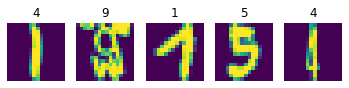

In [9]:
# K-Class Classifier Parameters:
Ker_Meth      = "Poly"
n_classes     = 10
n_classifiers = int(n_classes*(n_classes - 1)/2)
n_epochs      = 20

classifier_values = np.zeros((n_classifiers, 2))
idx = 0
for c1 in np.arange(10):
    for c2 in np.arange(c1+1,10):
        classifier_values[idx] = [c1, c2]
        idx += 1

# Question 1b):
Testing_Error_per_run  = []
d_star_per_run         = []

# Question 1c):
confusion_matrix       = []

# Question 1d):
prediction_mistake_count = np.zeros((Y_dataset.shape[0],1))

# Question 1b):
# Loop for 20 runs
for run in range(1,21):
    print("Run: {}".format(run))

    # 8:2 Split training + validation and testing set:
    # Index Shuffle for fitting:
    ran_sample_idx               = np.random.permutation(len(Y_dataset))
    split_pt                     = round(len(ran_sample_idx)*0.8)
    ran_trainvalidate_sample_idx = ran_sample_idx[:split_pt]
    ran_test_sample_idx          = ran_sample_idx[split_pt:len(ran_sample_idx)]
    n_train_validate_samples     = len(ran_trainvalidate_sample_idx)
    n_test_samples               = len(ran_test_sample_idx)
    
    # Loop for d from 1 to 7
    avg_validation_correct = [0]
    for Ker_para in range(1,8):
        print("d = {}".format(Ker_para))

        print("Precalculate Kernel...")
        KF  = KernelFunctor(Ker_Meth, Ker_para)
        tic = time.perf_counter()
        KN  = KF.kernel_fn(X_dataset) # Kernel matrix
        toc = time.perf_counter()
        print(f"**Kernel calculation finished in {toc - tic:0.4f} seconds")

        # 1b) 5 folds cross validation:
        validation_correct_all = []
        folds = 5
        for fold in range(0, folds):
            print(f"fold :{fold + 1}")

            # Get indicies for training set and validation set:
            data_train_idx, data_validate_idx = kFold(ran_trainvalidate_sample_idx, fold, folds)

            # Data sets:
            X_train              = X_dataset[data_train_idx]
            Y_train              = Y_dataset[data_train_idx]
            X_validate           = X_dataset[data_validate_idx]
            Y_validate           = Y_dataset[data_validate_idx]

            nsamples             = len(data_train_idx)

            # Initialize:
            alphas               = np.zeros((n_classifiers, nsamples))

            # Start Model:
            ovoop = OvO_OnlinePerceptron(alphas, classifier_values, KN, n_classes)

            for epoch in range(1, n_epochs + 1):
                tic    = time.time()
                alphas = ovoop.fit(data_train_idx, X_train, Y_train)
                toc    = time.time()
                
                print(f"**Training: Epoch {epoch} finished in {toc - tic:0.4f} seconds")
                epoch += 1
            
            # 1b) Validate:
            # ---------------Validation Accuracy-----------------
            validate_correct = 0

            kernel_vals      = KN[data_train_idx]
            kernel_vals      = kernel_vals[:, data_validate_idx]
            pred             = OvO_Prediction(alphas, kernel_vals, classifier_values)
            validate_correct = len(np.where((Y_validate - pred) == 0)[0])
            
            # 1b )Record results:
            validation_correct_all.append(validate_correct)

        # 1b) Save all average validation correct for selection:
        avg_validation_correct.append(np.sum(validation_correct_all)/folds)
    
    # 1b) Select the best d (d*)
    d_star = np.argmax(avg_validation_correct)

    # 1b) Retrain using d* on full 80% training set
    print(f"Retrain using {d_star}...")
    print("Precalculate Kernel...")
    KF  = KernelFunctor(Ker_Meth, d_star) # Use d_star
    tic = time.perf_counter()
    KN  = KF.kernel_fn(X_dataset) # Kernel matrix
    toc = time.perf_counter()
    print(f"**Kernel calculation finished in {toc - tic:0.4f} seconds")
    
    # Initialize:
    X_train_val = X_dataset[ran_trainvalidate_sample_idx]
    Y_train_val = Y_dataset[ran_trainvalidate_sample_idx]
    alphas = np.zeros((n_classifiers, n_train_validate_samples))

    # Start Model:
    ovoop = OvO_OnlinePerceptron(alphas, classifier_values, KN, n_classes)
    
    for epoch in range(1, n_epochs + 1):
        tic    = time.time()
        alphas = ovoop.fit(ran_trainvalidate_sample_idx, X_train_val, Y_train_val) # Full 80%
        toc    = time.time()
        
        print(f"**Training: Epoch {epoch} finished in {toc - tic:0.4f} seconds")
        epoch += 1
    
    # 1b) Test on testing set:
    # ---------------Testing Accuracy-------------------
    print("Testing:")
    X_test       = X_dataset[ran_test_sample_idx]
    Y_test       = Y_dataset[ran_test_sample_idx]
    Test_correct = 0

    kernel_vals  = KN[ran_trainvalidate_sample_idx]
    kernel_vals  = kernel_vals[:, ran_test_sample_idx]
    pred         = OvO_Prediction(alphas, kernel_vals, classifier_values)
    Test_correct = len(np.where((Y_test - pred.astype(int)) == 0)[0])

    # 1c) Fill confusion matrix:
    confusion_matrix_per_run = np.zeros((10,10)) # 0 - 9
    label_count = np.zeros((10,1))
    for i, j in zip(Y_test, pred.astype(int)):
        label_count[i] += 1
        if i != j:
            confusion_matrix_per_run[i,j] += 1
    confusion_matrix_per_run = confusion_matrix_per_run/label_count

    # 1b) Record test error and mean d*
    Test_error = (n_test_samples - Test_correct)/n_test_samples
    Testing_Error_per_run.append(Test_error)
    d_star_per_run.append(d_star)

    # 1c) Record confusion matrix:
    confusion_matrix.append(confusion_matrix_per_run)

    # 1d) 5 worst data:
    print("Prediction mistake count...")
    kernel_vals  = KN[ran_trainvalidate_sample_idx] # Take all for 2nd dimension
    pred         = OvO_Prediction(alphas, kernel_vals, classifier_values)
    # Record every mistake made for every sample for all 20 runs:
    for i in range(Y_dataset.shape[0]):
        if Y_dataset[i] != pred[i]:
            prediction_mistake_count[i] += 1

worst_5_idx = np.argsort(-prediction_mistake_count.T)[0,:5]


print("Results 1b):")
print(f"Testing error per run: {Testing_Error_per_run}")
print(f"d* per run: {d_star_per_run}")
print(f"Mean and STD of testing error: {np.mean(Testing_Error_per_run)} +- {np.std(Testing_Error_per_run)}")
print(f"Mean and STD of d*: {np.mean(d_star_per_run)} +- {np.std(d_star_per_run)}")

print("\nResults 1c):")
print(f"Mean confusion matrix:")
print(np.mean(confusion_matrix, axis = 0))
print(f"STD confusion matrix:")
print(np.std(confusion_matrix, axis = 0))

print("\nResults 1d):")
plot_idx = 1
for idx in worst_5_idx:
    plt.subplot(1, 5, plot_idx)
    img = np.reshape(X_dataset[idx], (16,16))
    plt.imshow(img)
    plt.axis('off')
    plt.title('%d' % Y_dataset[idx])
    plot_idx += 1